# Incremental ETL with Sycamore

In this demo, we'll show how you can use Sycamore, Pinecone and LangChain to answer complex questions over unstructured datasets. We'll ask detailed questions about ntsb flight accident reports.

*content warning: airplane accidents*

In [ ]:
#Install sycamore
!pip install sycamore-ai[pinecone]

#Install poppler to visualize PDFs with show_pages
!apt-get install poppler-utils
# !brew install poppler

Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish


==> Downloading https://ghcr.io/v2/homebrew/core/poppler/manifests/25.01.0
######################################################################### 100.0%
==> Fetching dependencies for poppler: ca-certificates, sqlite, python@3.13, gettext, glib, libxau, libxrender, pixman, libnghttp2, unbound, libgpg-error, libassuan, libksba, libusb, npth, pinentry, gnupg, gpgme, jpeg-turbo, nspr, nss and openjpeg
==> Downloading https://ghcr.io/v2/homebrew/core/ca-certificates/manifests/2024-
######################################################################### 100.0%
==> Fetching ca-certificates
==> Downloading https://ghcr.io/v2/homebrew/co

In [4]:
#Install all the langchain modules
!pip install langchain
!pip install langchain-anthropic
!pip install langchain_pinecone
!pip install langchain-huggingface
!pip install python-dotenv

Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Error executing CLI: 1 error occurred:
	* already installed at /Users/vincentwork/.config/fish/completions/terraform.fish



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Error executing CLI: 1 error occurred:
	* already installed 

In [5]:
# API Keys
import os
# from google.colab import userdata
from dotenv import load_dotenv
# Helper functions and objects
from sycamore.llms.openai import OpenAIModels, OpenAI
from sycamore.data import Element, Document
from PIL import Image, ImageOps
import sycamore
from sycamore.context import ExecMode
from sycamore.materialize import AutoMaterialize

In [13]:
load_dotenv()

#Add your variables in the Secrets page in Colab, and set them here
# ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')
# ARYN_API_KEY = os.getenv('ARYN_API_KEY')
# SINGLE_STORE_API_KEY = os.getenv('SINGLE_STORE_API_KEY')

True

To start with, we'll first segment the documents using Aryn DocParse. Then we'll apply a bunch of cleaning, chunking, and extraction operations to enhance the semantic meaningfulness of the sections of the document. Finally we'll embed the chunks and write them to Pinecone.

## Data

The documents we'll use are reports from the NTSB (National Transport Safety Board). Whenever there's a plane crash, the NTSB produces a document containing both structured and unstructured information contained in tables, free text, and images, that describes what went down (pun intended).

In [20]:
#uris = ["s3://aryn-public/ntsb/0.pdf", "s3://aryn-public/ntsb/1.pdf", "s3://aryn-public/ntsb/10.pdf", "s3://aryn-public/ntsb/101.pdf", "s3://aryn-public/ntsb/103.pdf", "s3://aryn-public/ntsb/104.pdf", "s3://aryn-public/ntsb/11.pdf", "s3://aryn-public/ntsb/12.pdf", "s3://aryn-public/ntsb/16.pdf", "s3://aryn-public/ntsb/18.pdf", "s3://aryn-public/ntsb/20.pdf", "s3://aryn-public/ntsb/21.pdf", "s3://aryn-public/ntsb/22.pdf", "s3://aryn-public/ntsb/23.pdf"
#, "s3://aryn-public/ntsb/25.pdf", "s3://aryn-public/ntsb/26.pdf", "s3://aryn-public/ntsb/27.pdf", "s3://aryn-public/ntsb/28.pdf", "s3://aryn-public/ntsb/3.pdf", "s3://aryn-public/ntsb/31.pdf", "s3://aryn-public/ntsb/32.pdf", "s3://aryn-public/ntsb/34.pdf", "s3://aryn-public/ntsb/35.pdf", "s3://aryn-public/ntsb/36.pdf", "s3://aryn-public/ntsb/37.pdf", "s3://aryn-public/ntsb/38.pdf", "s3://aryn-public/ntsb/39.pdf"
#, "s3://aryn-public/ntsb/40.pdf", "s3://aryn-public/ntsb/41.pdf", "s3://aryn-public/ntsb/42.pdf"]
uris = "s3://aryn-public/ntsb/"

ctx = sycamore.init(exec_mode=sycamore.EXEC_LOCAL)
ctx.rewrite_rules.append(AutoMaterialize(source_mode=sycamore.MATERIALIZE_USE_STORED))
doc = ctx.read.binary(paths=uris, binary_format="pdf")


sycamore.materialize - INFO - 2025-01-11 23:44:57,896 - Materialize directory was not specified. Used /var/folders/xs/dlkj21v91915ssch66ftg4y40000gp/T/materialize.2025-01-11T15:44:57


INFO:sycamore.materialize:Materialize directory was not specified. Used /var/folders/xs/dlkj21v91915ssch66ftg4y40000gp/T/materialize.2025-01-11T15:44:57


sycamore.executor - INFO - 2025-01-11 23:45:07,036 - Executing source BinaryScan


INFO:sycamore.executor:Executing source BinaryScan


sycamore.utils.pyarrow - WARNING - 2025-01-11 23:45:07,037 - path aryn-public/ntsb infers a filesystem of class <class 'pyarrow._fs.LocalFileSystem'> and a path of /Users/vincentwork/Documents/UCSB/SBHacksXI/aryn_pipeline/aryn-public/ntsb, but the specified filesystem is <class 'pyarrow._s3fs.S3FileSystem'>. Using the path unchanged.


sycamore.executor - INFO - 2025-01-11 23:45:37,051 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:45:37,205 - Executing node split_and_convert_to_image


INFO:sycamore.executor:Executing node split_and_convert_to_image


sycamore.executor - INFO - 2025-01-11 23:45:56,352 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:46:01,612 - Executing node Limit


INFO:sycamore.executor:Executing node Limit


sycamore.executor - INFO - 2025-01-11 23:46:01,697 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:46:01,801 - Executing node DrawBoxes


INFO:sycamore.executor:Executing node DrawBoxes


sycamore.executor - INFO - 2025-01-11 23:46:01,999 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


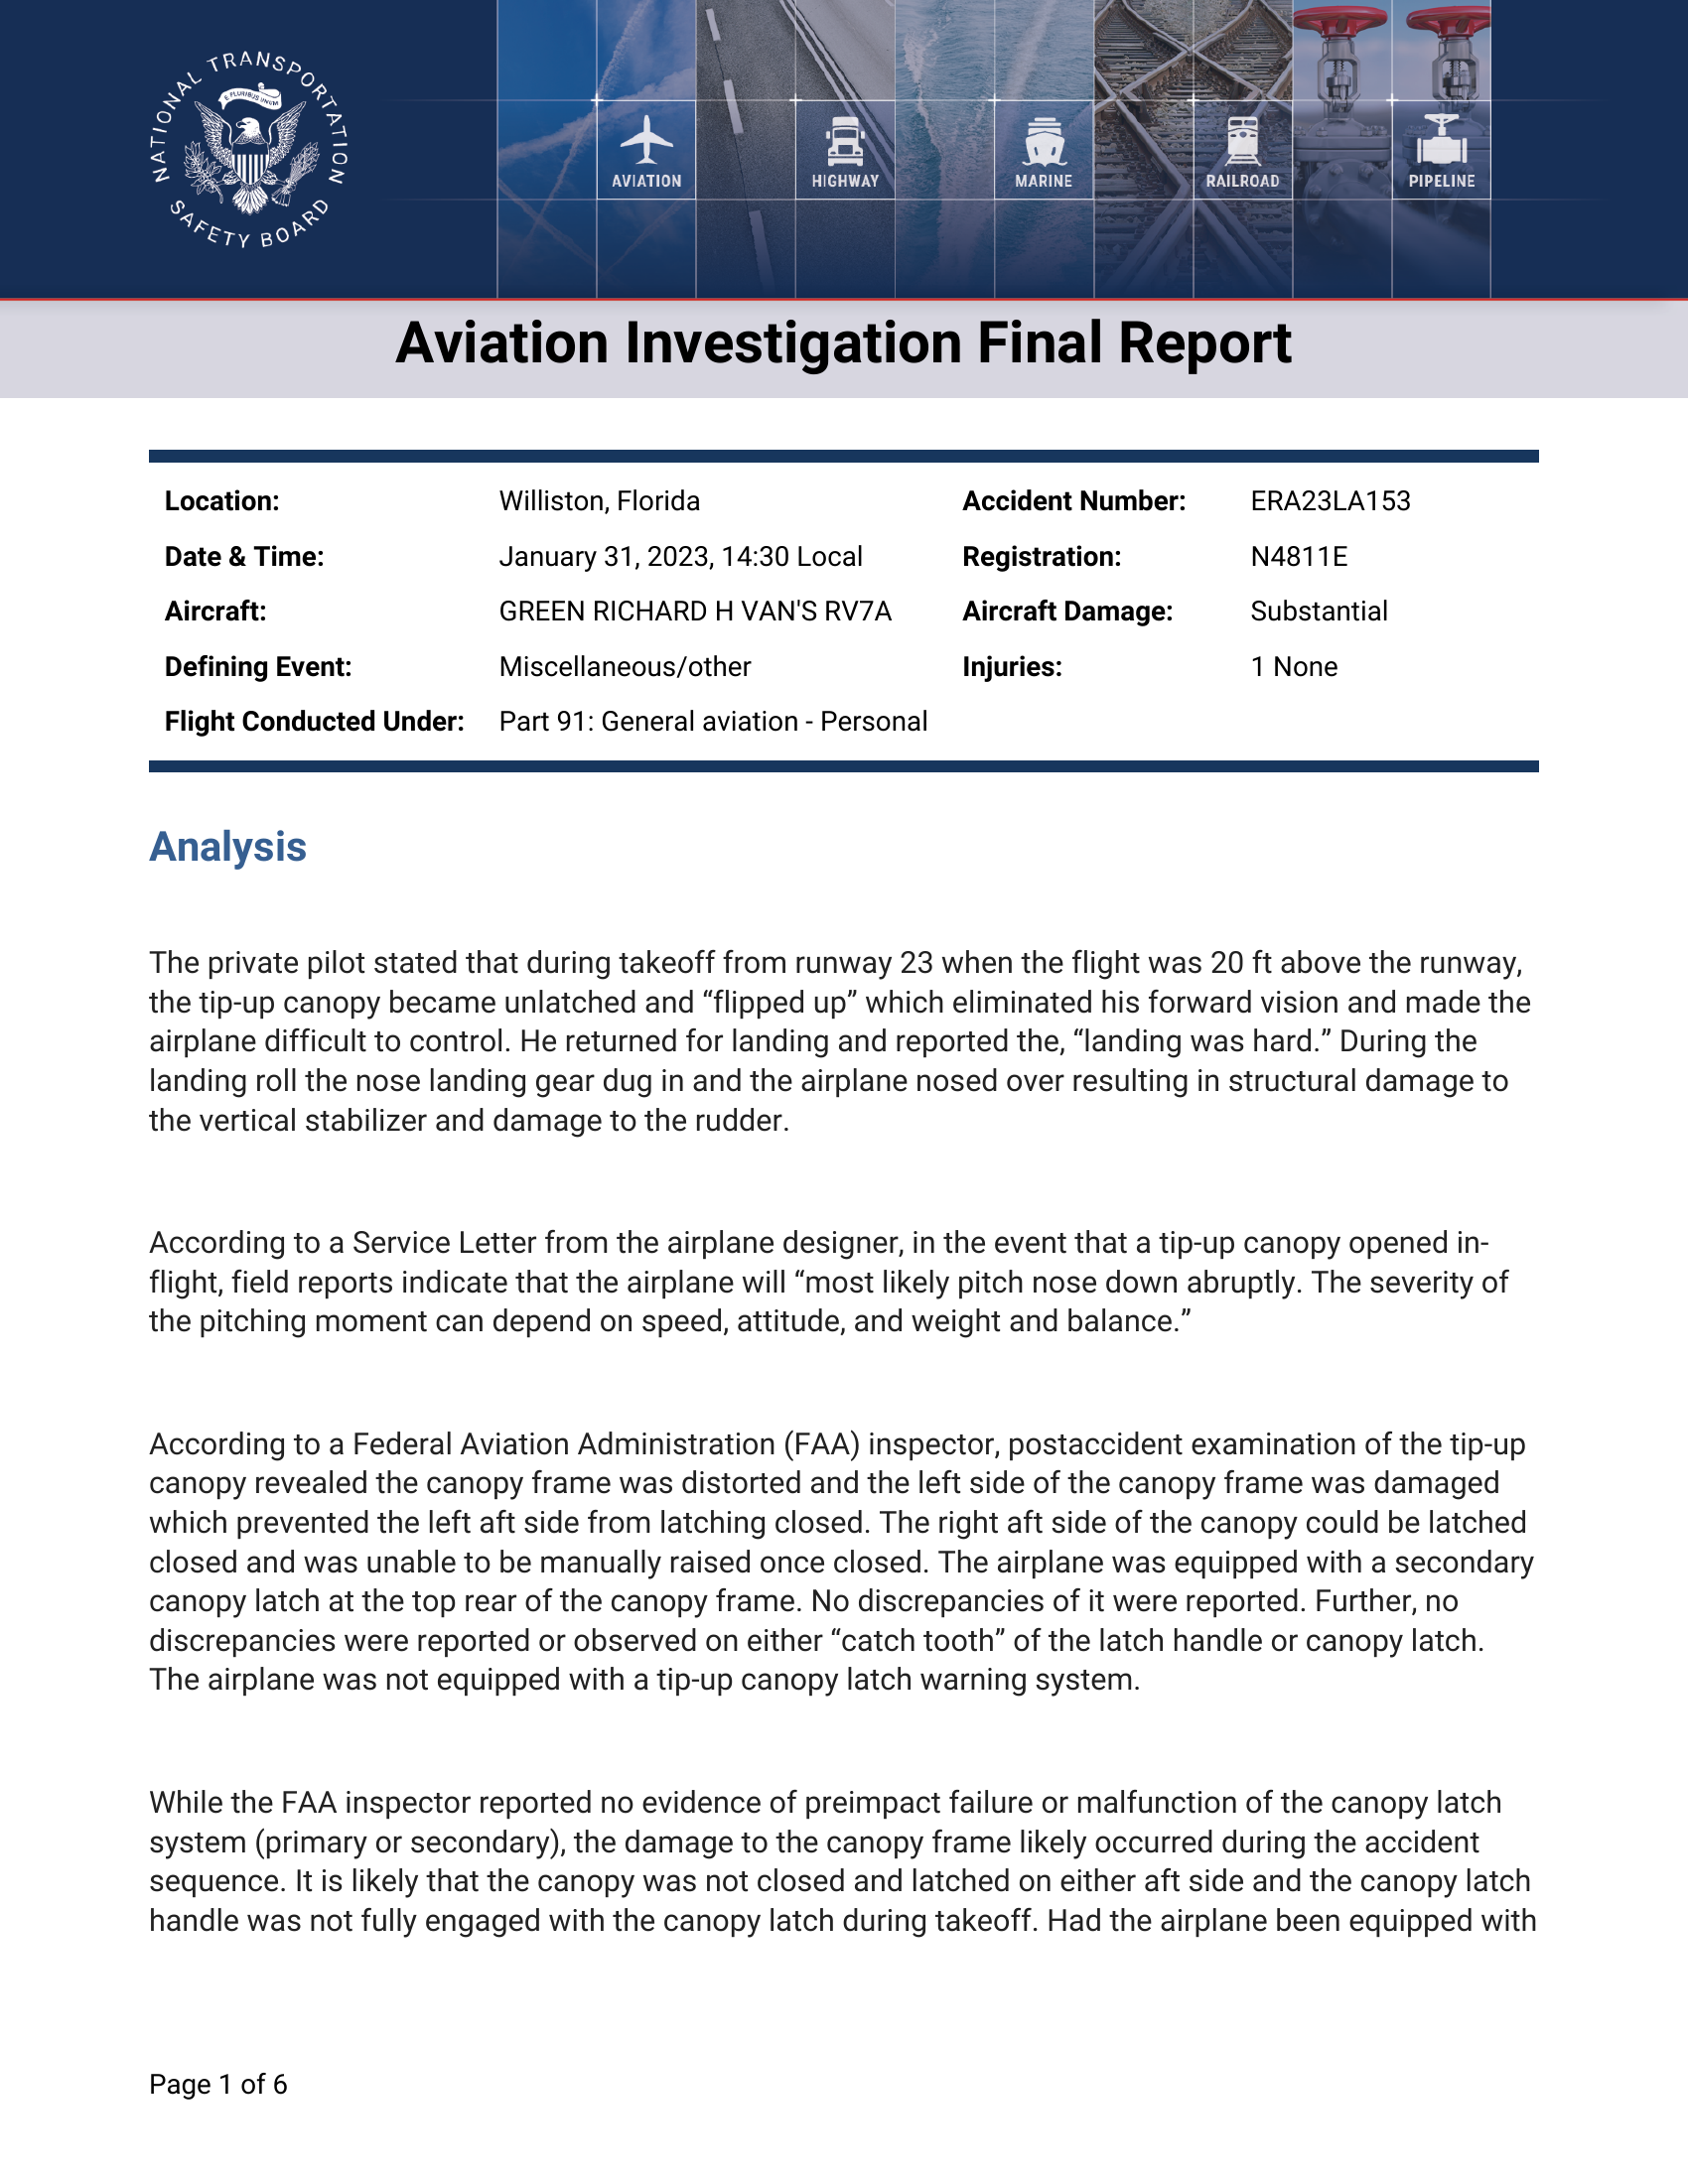

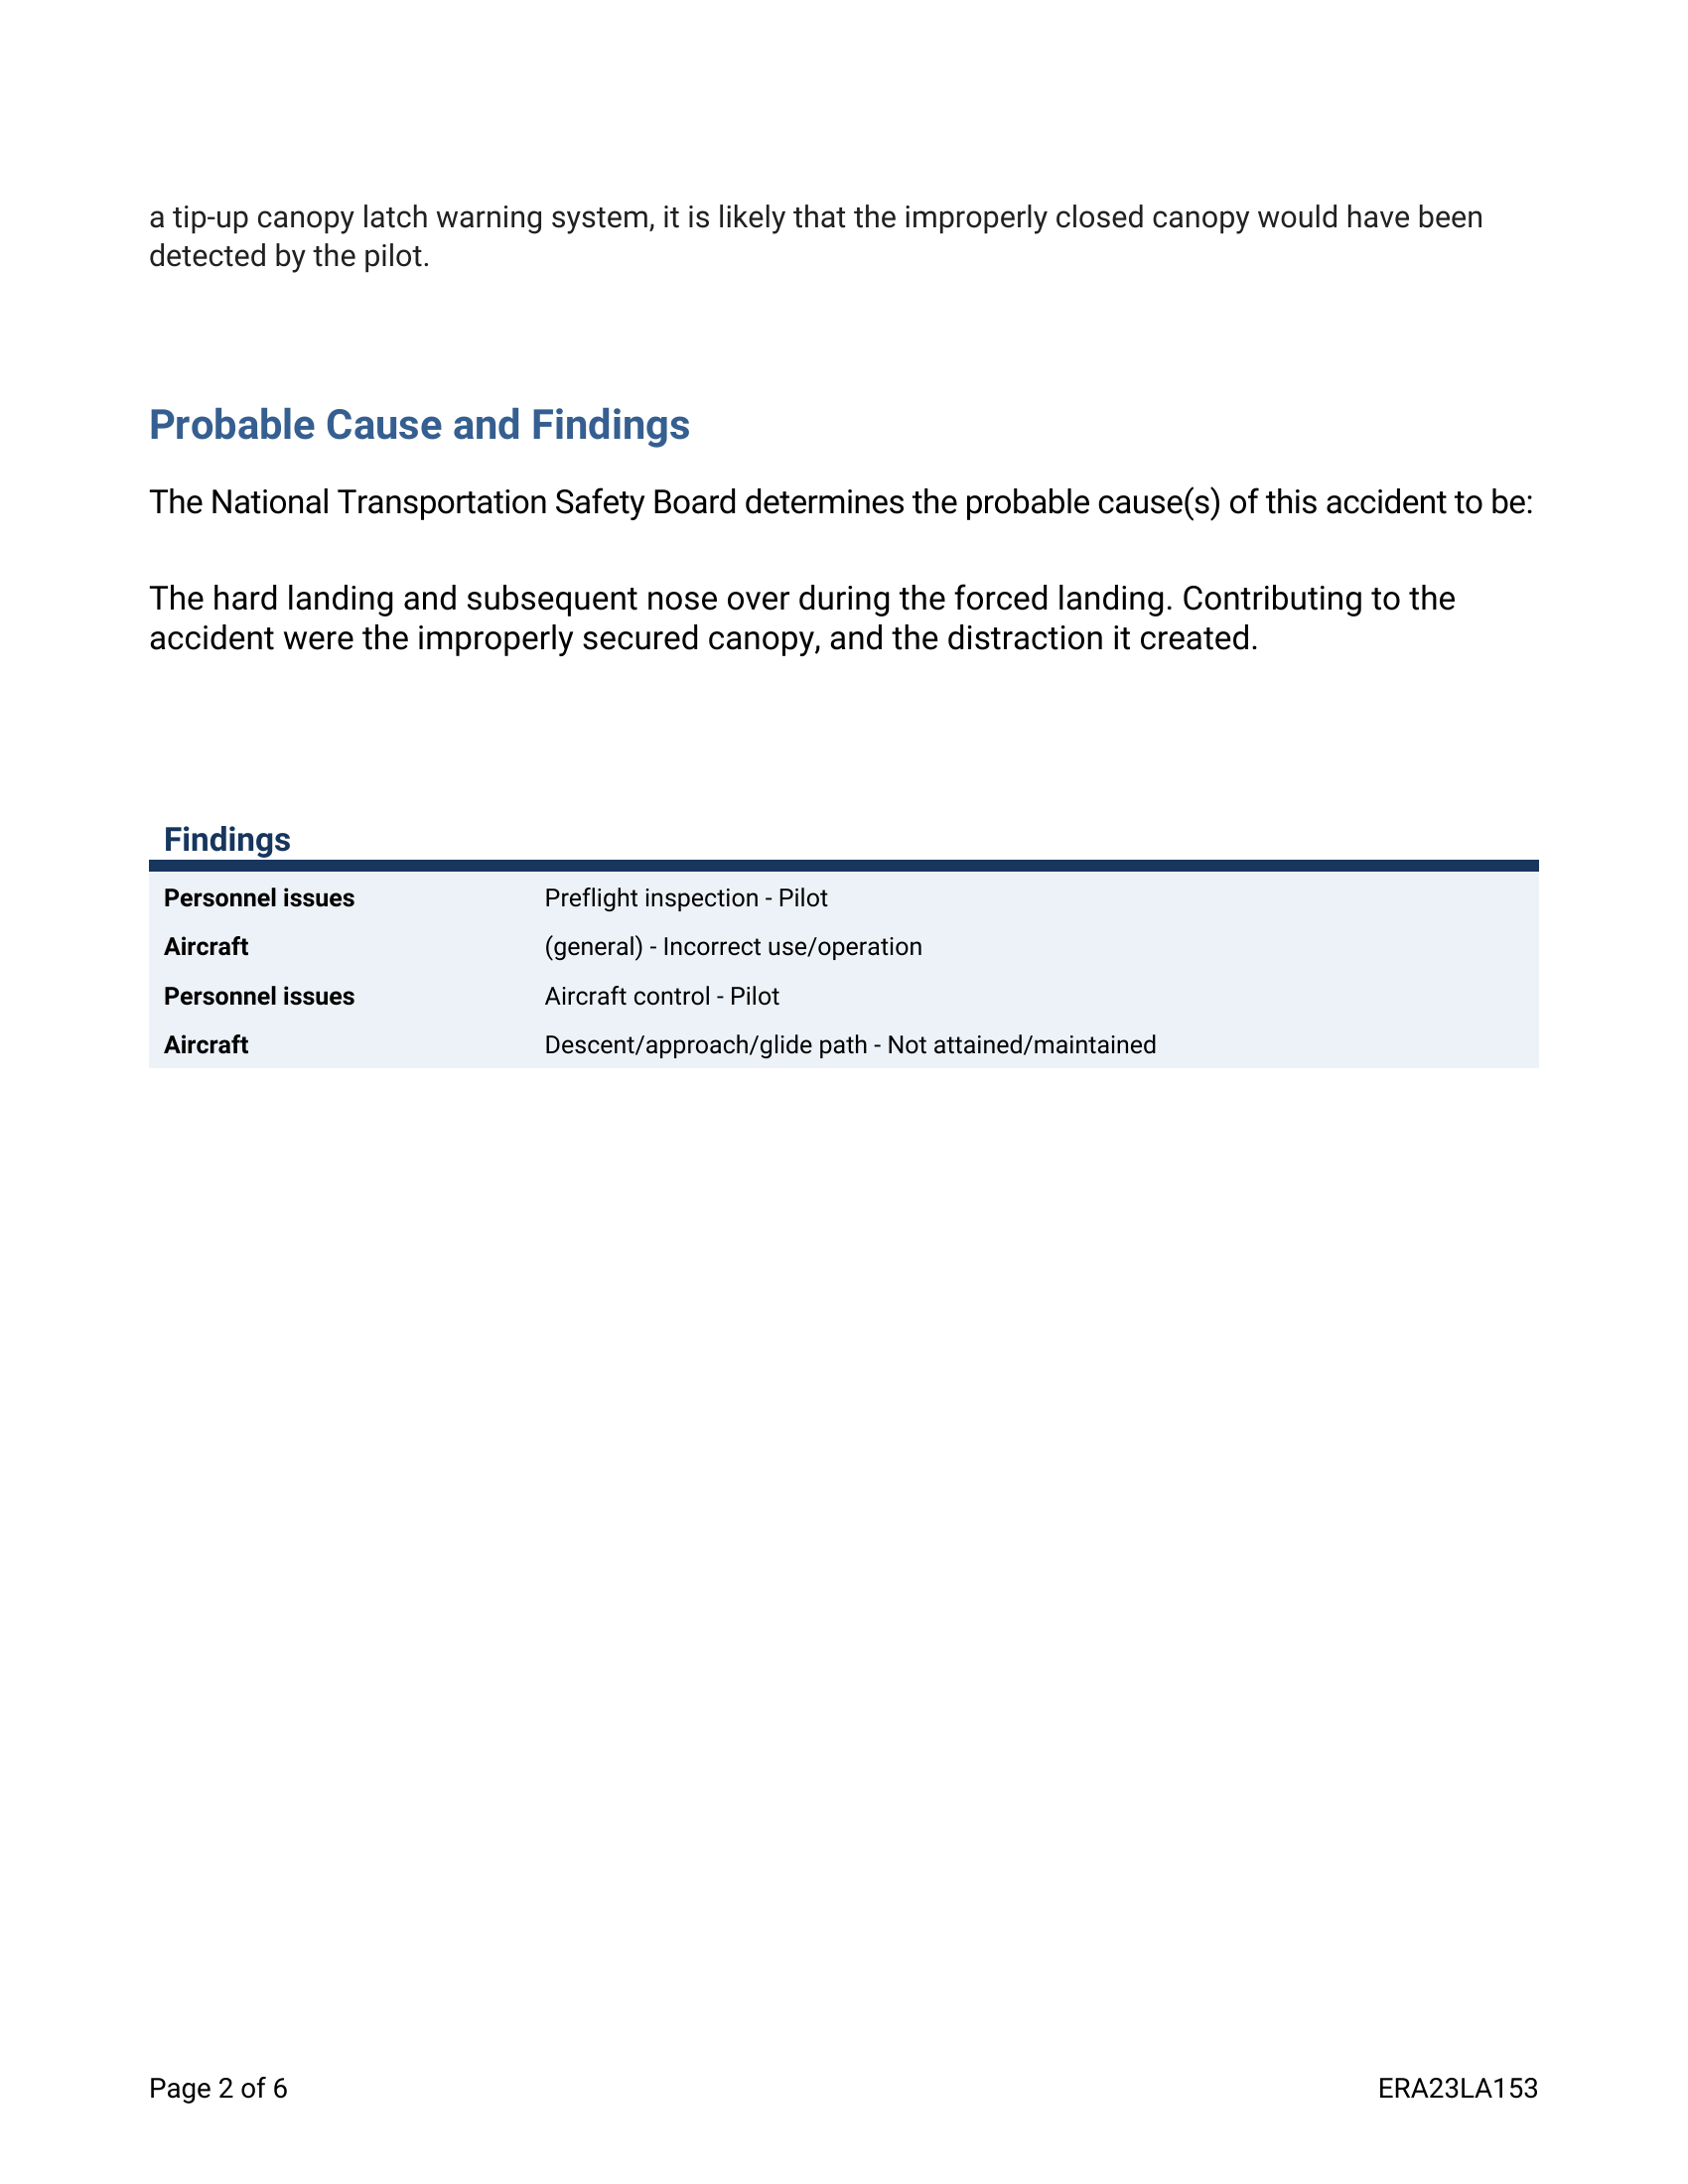

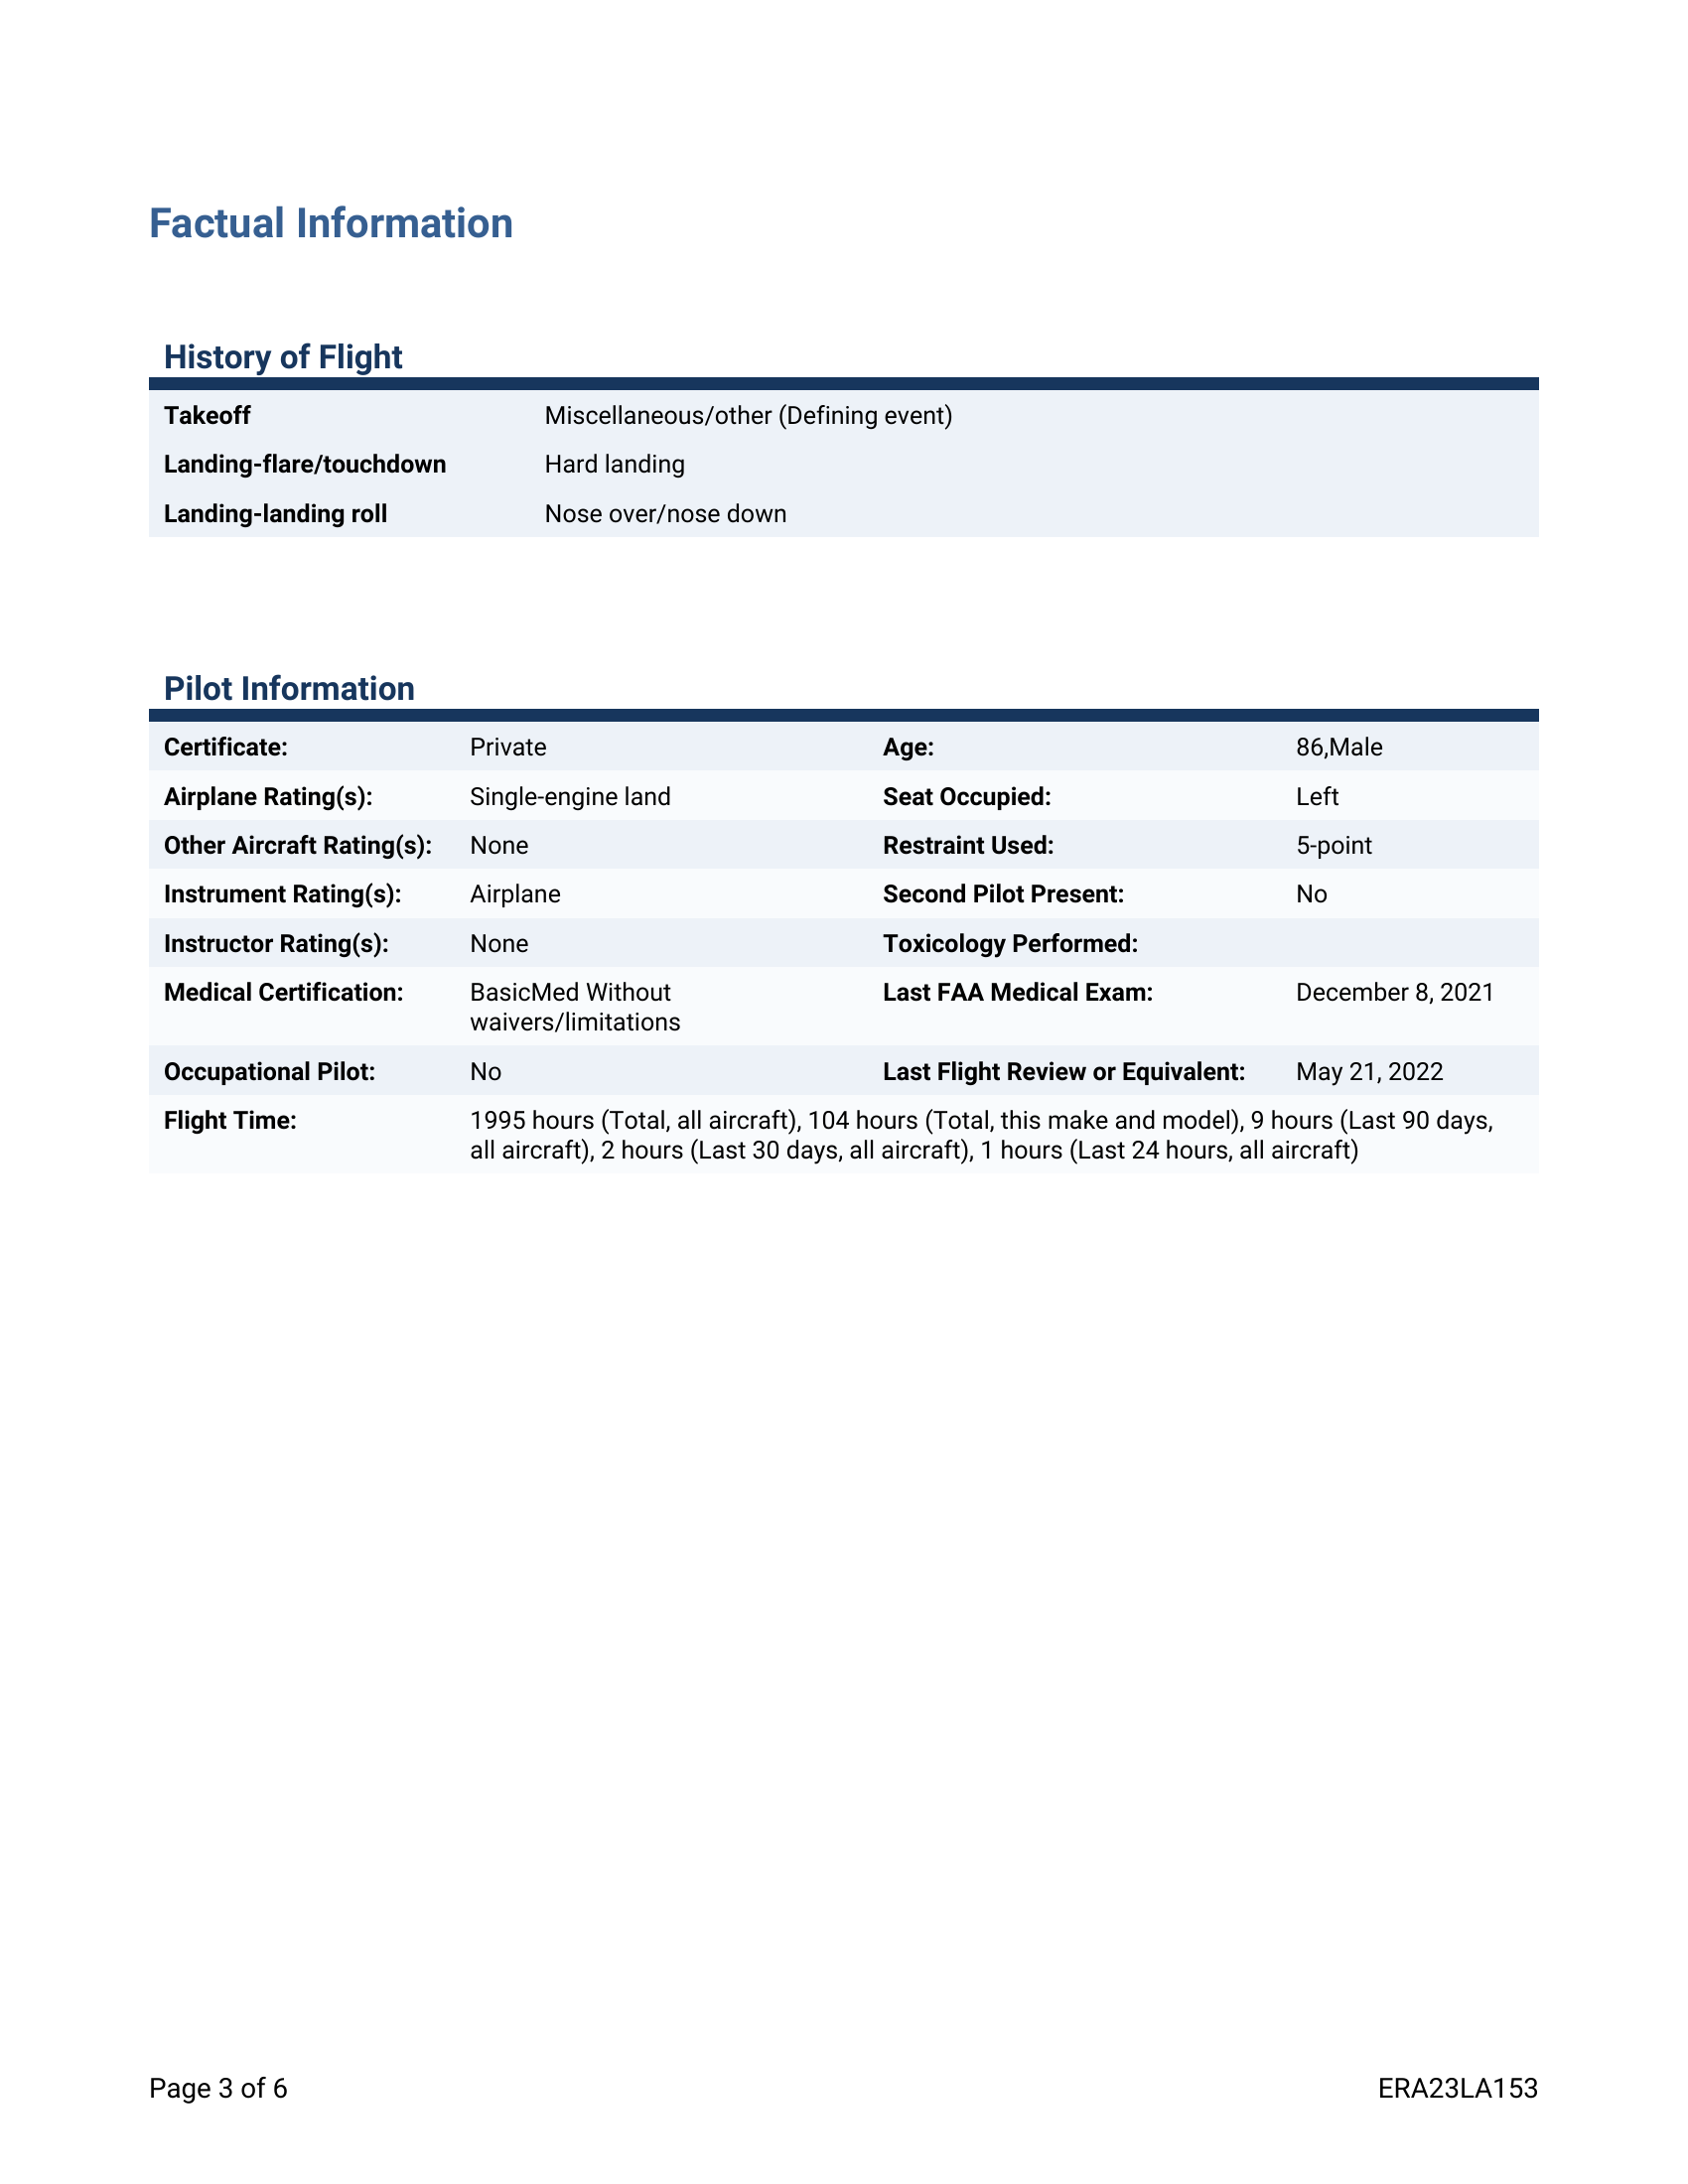

In [21]:
from sycamore.utils.pdf_utils import show_pages

show_pages(doc, limit=3)

## Partitioning

Document processing begins with document segmentation. Before we can do anything meaningful, we need a way to access the sections of the document, the contents of those sections, and the relations between those sections. The Aryn Partitioning Service provides this information. We'll call it through Sycamore's ArynPartitioner object.

sycamore.executor - INFO - 2025-01-11 23:47:15,079 - Executing source BinaryScan


INFO:sycamore.executor:Executing source BinaryScan


sycamore.utils.pyarrow - WARNING - 2025-01-11 23:47:15,080 - path aryn-public/ntsb infers a filesystem of class <class 'pyarrow._fs.LocalFileSystem'> and a path of /Users/vincentwork/Documents/UCSB/SBHacksXI/aryn_pipeline/aryn-public/ntsb, but the specified filesystem is <class 'pyarrow._s3fs.S3FileSystem'>. Using the path unchanged.


sycamore.executor - INFO - 2025-01-11 23:47:49,052 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:47:49,267 - Executing node Partition


INFO:sycamore.executor:Executing node Partition


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:51,390 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:51,392 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f44db563-c01b-49d8-8981-80863d9d8737


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f44db563-c01b-49d8-8981-80863d9d8737


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:51,394 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:51,395 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:51,396 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:52,387 - ArynPartitioner: T+   1.32: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:52,389 - ArynPartitioner: T+   1.56: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.56: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:52,391 - ArynPartitioner: T+   1.74: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.74: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:52,392 - ArynPartitioner: T+   1.96: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.96: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:53,515 - ArynPartitioner: T+   2.17: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.17: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:53,516 - ArynPartitioner: T+   2.31: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.31: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,834 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,837 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=00853f70-852a-4b3a-8228-82e577cfdaaa


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=00853f70-852a-4b3a-8228-82e577cfdaaa


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,839 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,840 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,842 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,843 - ArynPartitioner: T+   0.84: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:55,844 - ArynPartitioner: T+   0.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,332 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,334 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=8bbdf7ae-b0c7-4255-9107-56f1d48debc0


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=8bbdf7ae-b0c7-4255-9107-56f1d48debc0


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,335 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,335 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,336 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:58,337 - ArynPartitioner: T+   0.96: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.96: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:47:59,407 - ArynPartitioner: T+   1.03: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,730 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,735 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=31c678bc-bf79-463e-8429-e29fe635d3c9


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=31c678bc-bf79-463e-8429-e29fe635d3c9


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,737 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,739 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,739 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:01,741 - ArynPartitioner: T+   0.95: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.95: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:02,837 - ArynPartitioner: T+   1.23: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:02,838 - ArynPartitioner: T+   1.49: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:02,839 - ArynPartitioner: T+   1.80: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.80: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:02,840 - ArynPartitioner: T+   1.88: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.88: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,311 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,313 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a8ad117e-338d-4630-9479-638174787034


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a8ad117e-338d-4630-9479-638174787034


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,314 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,315 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,315 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:05,316 - ArynPartitioner: T+   0.99: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.99: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:06,513 - ArynPartitioner: T+   1.21: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.21: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:06,514 - ArynPartitioner: T+   1.45: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:06,515 - ArynPartitioner: T+   1.54: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.54: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:08,994 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:08,996 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=efd663af-d801-4a5b-bef5-aaa66794fd27


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=efd663af-d801-4a5b-bef5-aaa66794fd27


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:08,997 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:08,998 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:08,999 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:10,058 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:10,079 - ArynPartitioner: T+   1.28: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.28: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:10,080 - ArynPartitioner: T+   1.57: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:10,081 - ArynPartitioner: T+   1.86: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.86: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:10,082 - ArynPartitioner: T+   1.93: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.93: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,777 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,781 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=73541bfa-442b-48a1-8bba-f8f9f464f5bf


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=73541bfa-442b-48a1-8bba-f8f9f464f5bf


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,782 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,784 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,785 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,787 - ArynPartitioner: T+   0.73: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.73: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:16,788 - ArynPartitioner: T+   0.94: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.94: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:17,879 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,235 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,236 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=67221202-045d-4e91-a1fb-45f38d877c55


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=67221202-045d-4e91-a1fb-45f38d877c55


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,237 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,238 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,239 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,240 - ArynPartitioner: T+   0.90: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:20,241 - ArynPartitioner: T+   0.97: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.97: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:22,692 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:22,693 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f84efc2a-0c3f-4713-b02f-14286020fc5a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f84efc2a-0c3f-4713-b02f-14286020fc5a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:22,694 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:22,695 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:22,696 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:23,741 - ArynPartitioner: T+   1.08: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:23,742 - ArynPartitioner: T+   1.55: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:23,742 - ArynPartitioner: T+   1.79: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.79: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:24,843 - ArynPartitioner: T+   2.02: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:24,855 - ArynPartitioner: T+   2.14: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.14: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,261 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,262 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=9fb3f0ea-1b90-4c3a-bc0d-1edf11a3be36


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=9fb3f0ea-1b90-4c3a-bc0d-1edf11a3be36


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,263 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,264 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,264 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:27,265 - ArynPartitioner: T+   0.85: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:28,351 - ArynPartitioner: T+   1.06: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.06: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:28,371 - ArynPartitioner: T+   1.35: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.35: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:28,372 - ArynPartitioner: T+   1.45: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,706 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,708 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=6f69fe04-42d8-44e2-877d-1fb1d112ddd5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=6f69fe04-42d8-44e2-877d-1fb1d112ddd5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,709 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,711 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,712 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:30,713 - ArynPartitioner: T+   0.95: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.95: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:31,917 - ArynPartitioner: T+   1.18: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.18: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:31,917 - ArynPartitioner: T+   1.45: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:31,918 - ArynPartitioner: T+   1.66: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.66: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:31,919 - ArynPartitioner: T+   1.88: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.88: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,368 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,370 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=995eb021-0280-4003-b1ff-8c36f838a794


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=995eb021-0280-4003-b1ff-8c36f838a794


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,371 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,372 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,373 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,373 - ArynPartitioner: T+   0.75: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.75: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:34,374 - ArynPartitioner: T+   0.85: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,759 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,763 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c5f983cb-98a8-41f6-bdfe-c380f93f283a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c5f983cb-98a8-41f6-bdfe-c380f93f283a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,764 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,765 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,766 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:36,767 - ArynPartitioner: T+   0.85: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:37,769 - ArynPartitioner: T+   1.13: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.13: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:37,772 - ArynPartitioner: T+   1.40: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:37,773 - ArynPartitioner: T+   1.71: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.71: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:37,774 - ArynPartitioner: T+   1.98: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.98: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:38,873 - ArynPartitioner: T+   2.05: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.05: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,841 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,845 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=dd4276b1-3080-4f27-8af5-d111db5af519


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=dd4276b1-3080-4f27-8af5-d111db5af519


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,846 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,847 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,848 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,849 - ArynPartitioner: T+   0.85: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:41,851 - ArynPartitioner: T+   0.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,135 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,136 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=eeed6d1e-b31b-407b-b4e2-8e0a9cebaf23


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=eeed6d1e-b31b-407b-b4e2-8e0a9cebaf23


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,138 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,139 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,139 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,140 - ArynPartitioner: T+   0.72: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.72: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:44,141 - ArynPartitioner: T+   0.99: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.99: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:45,226 - ArynPartitioner: T+   1.21: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.21: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:45,233 - ArynPartitioner: T+   1.43: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.43: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:45,237 - ArynPartitioner: T+   1.57: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,584 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,588 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c166857f-16b1-46f9-8c73-7003083d7538


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c166857f-16b1-46f9-8c73-7003083d7538


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,588 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,589 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,589 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,590 - ArynPartitioner: T+   0.75: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.75: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:47,591 - ArynPartitioner: T+   0.82: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.82: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:50,157 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:50,160 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=365ad544-e127-4dff-94ea-15783ddb94db


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=365ad544-e127-4dff-94ea-15783ddb94db


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:50,163 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:50,164 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:50,165 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:51,284 - ArynPartitioner: T+   1.28: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.28: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:51,285 - ArynPartitioner: T+   1.68: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.68: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:51,285 - ArynPartitioner: T+   1.95: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.95: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:52,298 - ArynPartitioner: T+   2.27: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.27: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:52,300 - ArynPartitioner: T+   2.48: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.48: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:52,301 - ArynPartitioner: T+   2.73: Completed work on page 7


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.73: Completed work on page 7


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:52,305 - ArynPartitioner: T+   2.88: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.88: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,259 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,261 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=b7bb2dcb-6980-4408-a8e6-679712ac108c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=b7bb2dcb-6980-4408-a8e6-679712ac108c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,262 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,263 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,263 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:55,264 - ArynPartitioner: T+   0.86: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.86: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:56,339 - ArynPartitioner: T+   1.09: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:56,356 - ArynPartitioner: T+   1.31: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.31: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:56,357 - ArynPartitioner: T+   1.52: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.52: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:56,357 - ArynPartitioner: T+   1.83: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.83: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:56,358 - ArynPartitioner: T+   1.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:58,656 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:58,658 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5be0ce07-eb94-4ec6-a95d-c403f1cd9067


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5be0ce07-eb94-4ec6-a95d-c403f1cd9067


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:58,659 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:58,660 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:58,661 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:59,655 - ArynPartitioner: T+   1.01: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:59,658 - ArynPartitioner: T+   1.23: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:59,659 - ArynPartitioner: T+   1.59: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.59: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:48:59,660 - ArynPartitioner: T+   1.88: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.88: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:00,782 - ArynPartitioner: T+   2.16: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.16: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:00,783 - ArynPartitioner: T+   2.23: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.23: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,239 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,240 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=54b08e44-5d3b-4e6a-9652-75f57b218e0e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=54b08e44-5d3b-4e6a-9652-75f57b218e0e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,240 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,241 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,241 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,242 - ArynPartitioner: T+   0.79: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.79: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:03,242 - ArynPartitioner: T+   0.88: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.88: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,575 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,579 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=b65efecd-e1ab-402d-8559-52c62e3a0395


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=b65efecd-e1ab-402d-8559-52c62e3a0395


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,580 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,581 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,583 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:05,583 - ArynPartitioner: T+   0.94: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.94: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:06,730 - ArynPartitioner: T+   1.23: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:06,731 - ArynPartitioner: T+   1.52: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.52: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:06,731 - ArynPartitioner: T+   1.80: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.80: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:06,732 - ArynPartitioner: T+   1.87: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.87: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:09,107 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:09,109 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=2301f42b-867a-4ed7-9585-bc903e38ebcf


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=2301f42b-867a-4ed7-9585-bc903e38ebcf


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:09,112 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:09,113 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:09,114 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:10,070 - ArynPartitioner: T+   1.14: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.14: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:10,070 - ArynPartitioner: T+   1.72: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.72: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:10,071 - ArynPartitioner: T+   1.97: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.97: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:11,201 - ArynPartitioner: T+   2.18: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.18: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:11,201 - ArynPartitioner: T+   2.41: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.41: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:11,202 - ArynPartitioner: T+   2.53: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.53: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,703 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,706 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=0147f98d-36b3-483a-9ff2-8f41dcfc54a9


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=0147f98d-36b3-483a-9ff2-8f41dcfc54a9


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,707 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,708 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,709 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,711 - ArynPartitioner: T+   0.83: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:13,713 - ArynPartitioner: T+   0.90: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,118 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,120 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=24c24412-d939-429d-a2a7-750334c222f1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=24c24412-d939-429d-a2a7-750334c222f1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,121 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,122 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,123 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:16,124 - ArynPartitioner: T+   0.90: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:17,195 - ArynPartitioner: T+   1.17: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:17,196 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:17,197 - ArynPartitioner: T+   1.53: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.53: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,573 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,574 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=fbf381e5-547e-4106-b8f8-6cc9349d3821


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=fbf381e5-547e-4106-b8f8-6cc9349d3821


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,575 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,576 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,578 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:19,579 - ArynPartitioner: T+   0.80: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.80: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:20,769 - ArynPartitioner: T+   1.01: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:20,769 - ArynPartitioner: T+   1.36: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.36: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:20,770 - ArynPartitioner: T+   1.44: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:23,339 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:23,345 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bc50be42-27da-4f10-9842-a470d240e533


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bc50be42-27da-4f10-9842-a470d240e533


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:23,346 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:23,348 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:23,349 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:24,363 - ArynPartitioner: T+   1.23: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:24,365 - ArynPartitioner: T+   1.70: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.70: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:24,366 - ArynPartitioner: T+   1.93: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.93: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:25,351 - ArynPartitioner: T+   2.15: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.15: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:25,352 - ArynPartitioner: T+   2.40: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.40: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:25,353 - ArynPartitioner: T+   2.47: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.47: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,671 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,673 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=4852ad94-0e60-4976-95c4-653acc97ec1b


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=4852ad94-0e60-4976-95c4-653acc97ec1b


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,674 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,675 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,677 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:27,679 - ArynPartitioner: T+   0.98: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.98: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:28,771 - ArynPartitioner: T+   1.27: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.27: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:28,773 - ArynPartitioner: T+   1.55: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:28,774 - ArynPartitioner: T+   1.77: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.77: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:29,769 - ArynPartitioner: T+   2.01: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.01: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:29,771 - ArynPartitioner: T+   2.13: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.13: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:32,145 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:32,148 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=7eee98c6-0e70-4879-a640-0458c4cf3d5d


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=7eee98c6-0e70-4879-a640-0458c4cf3d5d


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:32,149 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:32,150 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:32,151 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:33,257 - ArynPartitioner: T+   1.09: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:33,262 - ArynPartitioner: T+   1.30: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.30: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:33,263 - ArynPartitioner: T+   1.54: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.54: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,626 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,628 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=1b7dd17e-9610-44de-bdec-fb58ad6b525f


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=1b7dd17e-9610-44de-bdec-fb58ad6b525f


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,630 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,631 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,632 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:35,632 - ArynPartitioner: T+   0.93: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.93: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:36,728 - ArynPartitioner: T+   1.15: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.15: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:36,746 - ArynPartitioner: T+   1.36: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.36: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:36,747 - ArynPartitioner: T+   1.57: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:36,748 - ArynPartitioner: T+   1.87: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.87: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:36,748 - ArynPartitioner: T+   1.93: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.93: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,503 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,505 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=0bff40d4-1763-4267-b672-79e09fb6a559


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=0bff40d4-1763-4267-b672-79e09fb6a559


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,506 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,507 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,508 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,509 - ArynPartitioner: T+   0.90: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:39,511 - ArynPartitioner: T+   0.96: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.96: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,976 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,980 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a443c70e-ccf2-450b-aa54-1436cc378459


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a443c70e-ccf2-450b-aa54-1436cc378459


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,981 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,982 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,983 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:41,984 - ArynPartitioner: T+   0.82: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.82: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:42,945 - ArynPartitioner: T+   1.08: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:42,946 - ArynPartitioner: T+   1.18: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.18: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,305 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,308 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=65cfe8ba-7453-4e92-a8ea-b84641bbde35


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=65cfe8ba-7453-4e92-a8ea-b84641bbde35


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,309 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,310 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,312 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:45,314 - ArynPartitioner: T+   0.93: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.93: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:46,309 - ArynPartitioner: T+   1.26: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.26: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:46,311 - ArynPartitioner: T+   1.55: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:46,313 - ArynPartitioner: T+   1.86: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.86: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:47,492 - ArynPartitioner: T+   2.13: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.13: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:47,493 - ArynPartitioner: T+   2.20: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.20: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,968 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,970 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f00ec4ed-477f-4e80-bcd4-356db8f7ae04


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f00ec4ed-477f-4e80-bcd4-356db8f7ae04


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,971 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,971 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,972 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:49,972 - ArynPartitioner: T+   0.97: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.97: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:51,006 - ArynPartitioner: T+   1.17: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:51,007 - ArynPartitioner: T+   1.38: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:51,007 - ArynPartitioner: T+   1.45: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,855 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,858 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bdd44432-2781-44bb-be9f-14a418f56aad


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bdd44432-2781-44bb-be9f-14a418f56aad


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,859 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,860 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,861 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:53,862 - ArynPartitioner: T+   0.99: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.99: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:54,780 - ArynPartitioner: T+   1.24: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:54,783 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:54,785 - ArynPartitioner: T+   1.74: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.74: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:54,785 - ArynPartitioner: T+   1.97: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.97: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:55,886 - ArynPartitioner: T+   2.09: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.09: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,257 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,257 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=030df8c8-0351-46ef-b450-54595ed97d50


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=030df8c8-0351-46ef-b450-54595ed97d50


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,258 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,258 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,259 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:58,259 - ArynPartitioner: T+   0.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:49:59,309 - ArynPartitioner: T+   1.01: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:01,941 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:01,944 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=296f036a-09cb-4384-9feb-a1256214b3ec


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=296f036a-09cb-4384-9feb-a1256214b3ec


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:01,946 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:01,947 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:01,948 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:02,761 - ArynPartitioner: T+   1.16: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.16: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:02,764 - ArynPartitioner: T+   1.78: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.78: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:03,893 - ArynPartitioner: T+   2.07: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.07: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:03,893 - ArynPartitioner: T+   2.35: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.35: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:03,894 - ArynPartitioner: T+   2.66: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.66: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:03,894 - ArynPartitioner: T+   2.75: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.75: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,248 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,251 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=16294fef-857a-4420-81a9-bf9593ff13c9


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=16294fef-857a-4420-81a9-bf9593ff13c9


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,253 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,255 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,256 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:07,257 - ArynPartitioner: T+   0.83: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:08,510 - ArynPartitioner: T+   1.05: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:08,511 - ArynPartitioner: T+   1.32: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:08,512 - ArynPartitioner: T+   1.39: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.39: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,177 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,180 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=936a86cd-7653-4985-82d0-772e5ac1f95d


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=936a86cd-7653-4985-82d0-772e5ac1f95d


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,182 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,183 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,184 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:11,185 - ArynPartitioner: T+   0.84: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:12,586 - ArynPartitioner: T+   1.09: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:12,588 - ArynPartitioner: T+   1.39: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.39: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:12,589 - ArynPartitioner: T+   1.47: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.47: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:21,111 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:21,114 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d199c2de-ce6f-4975-928b-70a4db435f99


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d199c2de-ce6f-4975-928b-70a4db435f99


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:21,115 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:21,116 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:21,117 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:22,033 - ArynPartitioner: T+   1.08: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:22,036 - ArynPartitioner: T+   1.53: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.53: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:22,037 - ArynPartitioner: T+   1.74: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.74: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:22,039 - ArynPartitioner: T+   1.95: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.95: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:23,286 - ArynPartitioner: T+   2.16: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.16: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:23,287 - ArynPartitioner: T+   2.32: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.32: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:27,030 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:27,032 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=6f770a96-7b33-43f5-baee-1369882d35da


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=6f770a96-7b33-43f5-baee-1369882d35da


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:27,033 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:27,034 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:27,035 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:28,132 - ArynPartitioner: T+   1.11: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.11: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:28,132 - ArynPartitioner: T+   1.34: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.34: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:28,133 - ArynPartitioner: T+   1.55: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:28,133 - ArynPartitioner: T+   1.76: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.76: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:28,134 - ArynPartitioner: T+   1.83: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.83: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:31,758 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:31,761 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6855752-a195-4a87-8655-0e163812d0c2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6855752-a195-4a87-8655-0e163812d0c2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:31,762 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:31,762 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:31,763 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:32,765 - ArynPartitioner: T+   1.23: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:32,766 - ArynPartitioner: T+   1.64: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.64: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:32,766 - ArynPartitioner: T+   1.91: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.91: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:33,868 - ArynPartitioner: T+   2.22: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.22: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:33,871 - ArynPartitioner: T+   2.51: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.51: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:33,873 - ArynPartitioner: T+   2.58: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.58: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:36,151 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:36,165 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=9c661802-6708-406b-8f1b-18c2ce11b849


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=9c661802-6708-406b-8f1b-18c2ce11b849


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:36,166 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:36,167 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:36,168 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:37,167 - ArynPartitioner: T+   1.00: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.00: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:37,170 - ArynPartitioner: T+   1.21: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.21: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:37,171 - ArynPartitioner: T+   1.56: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.56: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:37,173 - ArynPartitioner: T+   1.84: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.84: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:38,274 - ArynPartitioner: T+   2.08: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.08: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:38,276 - ArynPartitioner: T+   2.21: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.21: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,959 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,960 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=b97c8b71-3920-448c-9e44-25b691acd73a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=b97c8b71-3920-448c-9e44-25b691acd73a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,960 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,961 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,961 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,962 - ArynPartitioner: T+   0.79: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.79: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:40,962 - ArynPartitioner: T+   1.00: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.00: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:41,966 - ArynPartitioner: T+   1.08: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,970 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,974 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=99bd12b6-41f0-4495-b814-4a2eb84bc438


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=99bd12b6-41f0-4495-b814-4a2eb84bc438


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,975 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,976 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,978 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:44,980 - ArynPartitioner: T+   0.70: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.70: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:46,162 - ArynPartitioner: T+   1.09: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:46,167 - ArynPartitioner: T+   1.38: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:46,184 - ArynPartitioner: T+   1.50: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.50: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,630 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,633 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f46beff0-9071-4a81-a496-25b1f2b1fa1c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f46beff0-9071-4a81-a496-25b1f2b1fa1c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,634 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,635 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,636 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,638 - ArynPartitioner: T+   0.80: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.80: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:48,639 - ArynPartitioner: T+   0.89: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,404 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,406 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=61e9b2d3-7741-41e4-a878-e19320fb9643


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=61e9b2d3-7741-41e4-a878-e19320fb9643


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,407 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,407 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,408 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:51,408 - ArynPartitioner: T+   0.98: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.98: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:52,283 - ArynPartitioner: T+   1.25: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.25: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:52,284 - ArynPartitioner: T+   1.57: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:52,285 - ArynPartitioner: T+   1.67: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.67: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,988 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,991 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=492a4e22-cef9-4514-87ad-80b3815ae627


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=492a4e22-cef9-4514-87ad-80b3815ae627


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,992 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,993 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,995 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:54,996 - ArynPartitioner: T+   0.91: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:55,889 - ArynPartitioner: T+   1.12: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:55,891 - ArynPartitioner: T+   1.40: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:55,893 - ArynPartitioner: T+   1.61: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.61: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:55,895 - ArynPartitioner: T+   1.95: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.95: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:57,016 - ArynPartitioner: T+   2.02: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,699 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,700 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=01e95be6-f261-444c-8978-343dec5ebf4c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=01e95be6-f261-444c-8978-343dec5ebf4c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,700 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,701 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,702 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,702 - ArynPartitioner: T+   0.78: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.78: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:50:59,703 - ArynPartitioner: T+   1.00: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.00: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:00,810 - ArynPartitioner: T+   1.20: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.20: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:00,817 - ArynPartitioner: T+   1.49: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:00,817 - ArynPartitioner: T+   1.58: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.58: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,891 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,899 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=3a971613-acfb-4633-bd7e-bb2bef4bb91d


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=3a971613-acfb-4633-bd7e-bb2bef4bb91d


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,900 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,902 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,903 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:40,904 - ArynPartitioner: T+   0.99: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.99: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:41,970 - ArynPartitioner: T+   1.27: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.27: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:41,971 - ArynPartitioner: T+   1.67: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.67: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:41,972 - ArynPartitioner: T+   1.87: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.87: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:41,972 - ArynPartitioner: T+   1.94: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.94: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,569 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,571 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=8a45ffbf-91d8-4624-abbd-0884b7f3d058


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=8a45ffbf-91d8-4624-abbd-0884b7f3d058


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,572 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,573 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,574 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:44,575 - ArynPartitioner: T+   0.91: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:45,672 - ArynPartitioner: T+   1.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:45,699 - ArynPartitioner: T+   1.43: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.43: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:45,699 - ArynPartitioner: T+   1.63: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.63: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:45,700 - ArynPartitioner: T+   1.86: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.86: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:45,700 - ArynPartitioner: T+   1.92: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.92: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,947 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,953 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=41e46133-796a-49a7-b1dd-ea367f8fff09


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=41e46133-796a-49a7-b1dd-ea367f8fff09


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,954 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,956 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,957 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:47,958 - ArynPartitioner: T+   0.84: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:49,052 - ArynPartitioner: T+   1.11: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.11: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:49,072 - ArynPartitioner: T+   1.34: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.34: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:49,072 - ArynPartitioner: T+   1.49: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,327 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,330 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=13c21313-a8a9-4a5d-acd1-75f44bb3cace


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=13c21313-a8a9-4a5d-acd1-75f44bb3cace


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,331 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,332 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,333 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:51,334 - ArynPartitioner: T+   0.88: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.88: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:52,426 - ArynPartitioner: T+   1.10: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:52,428 - ArynPartitioner: T+   1.17: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,808 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,812 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f918f31b-1e88-4a38-8421-f6a2042861ef


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f918f31b-1e88-4a38-8421-f6a2042861ef


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,814 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,815 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,815 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:54,816 - ArynPartitioner: T+   0.87: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.87: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:55,844 - ArynPartitioner: T+   1.08: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:55,846 - ArynPartitioner: T+   1.29: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.29: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:55,847 - ArynPartitioner: T+   1.36: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.36: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,813 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,815 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a593b488-b377-40a1-a785-99d609170b6e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a593b488-b377-40a1-a785-99d609170b6e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,816 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,818 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,819 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:58,820 - ArynPartitioner: T+   0.84: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:59,903 - ArynPartitioner: T+   1.05: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:59,922 - ArynPartitioner: T+   1.38: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:51:59,922 - ArynPartitioner: T+   1.49: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,158 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,162 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=9ff548c1-ef0b-4268-8d35-b363ae95bb7c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=9ff548c1-ef0b-4268-8d35-b363ae95bb7c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,164 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,165 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,166 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:02,168 - ArynPartitioner: T+   0.88: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.88: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:03,285 - ArynPartitioner: T+   1.08: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:03,289 - ArynPartitioner: T+   1.32: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:03,290 - ArynPartitioner: T+   1.53: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.53: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:03,291 - ArynPartitioner: T+   1.82: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.82: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:03,291 - ArynPartitioner: T+   1.90: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.90: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,560 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,564 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=85056afd-02b6-4604-bb49-5e107733c66e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=85056afd-02b6-4604-bb49-5e107733c66e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,565 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,566 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,567 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:05,569 - ArynPartitioner: T+   0.81: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:06,627 - ArynPartitioner: T+   1.02: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.02: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:06,628 - ArynPartitioner: T+   1.40: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:06,628 - ArynPartitioner: T+   1.65: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.65: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:06,629 - ArynPartitioner: T+   1.73: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.73: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,942 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,945 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=df75f95a-9f3a-4abf-9d58-5976c07bf913


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=df75f95a-9f3a-4abf-9d58-5976c07bf913


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,947 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,948 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,949 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:08,949 - ArynPartitioner: T+   0.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:10,043 - ArynPartitioner: T+   1.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:10,059 - ArynPartitioner: T+   1.38: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:10,060 - ArynPartitioner: T+   1.62: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.62: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:10,060 - ArynPartitioner: T+   1.69: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.69: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,423 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,424 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=fa94ff06-643d-4e73-b352-24177b9b987a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=fa94ff06-643d-4e73-b352-24177b9b987a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,425 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,426 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,426 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:12,427 - ArynPartitioner: T+   0.87: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.87: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:13,442 - ArynPartitioner: T+   1.06: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.06: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:13,444 - ArynPartitioner: T+   1.35: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.35: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:13,444 - ArynPartitioner: T+   1.55: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:13,445 - ArynPartitioner: T+   1.66: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.66: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,777 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,779 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=4be9c57b-2d68-4c0d-bc6b-d61bc4668648


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=4be9c57b-2d68-4c0d-bc6b-d61bc4668648


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,781 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,782 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,783 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,784 - ArynPartitioner: T+   0.83: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:15,785 - ArynPartitioner: T+   0.89: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:18,157 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:18,158 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=2378719e-f4f2-4e8a-ace7-ae8bb1914b9c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=2378719e-f4f2-4e8a-ace7-ae8bb1914b9c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:18,159 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:18,160 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:18,161 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:19,148 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:19,149 - ArynPartitioner: T+   1.17: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,435 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,439 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=af628356-f74f-49a2-90cc-6b7ad3d91353


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=af628356-f74f-49a2-90cc-6b7ad3d91353


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,441 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,442 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,443 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:21,445 - ArynPartitioner: T+   0.69: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.69: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:22,535 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:22,536 - ArynPartitioner: T+   1.14: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.14: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,844 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,845 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c241eba0-75d1-46d2-a4c9-50a125c286a1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c241eba0-75d1-46d2-a4c9-50a125c286a1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,845 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,846 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,847 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,847 - ArynPartitioner: T+   0.72: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.72: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:24,848 - ArynPartitioner: T+   0.93: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.93: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:25,926 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,294 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,296 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d21ff5ba-0b25-47be-b2eb-c236d9a45360


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d21ff5ba-0b25-47be-b2eb-c236d9a45360


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,298 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,299 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,299 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:28,300 - ArynPartitioner: T+   0.92: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.92: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:29,254 - ArynPartitioner: T+   1.13: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.13: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:29,257 - ArynPartitioner: T+   1.35: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.35: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:29,265 - ArynPartitioner: T+   1.62: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.62: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:29,266 - ArynPartitioner: T+   1.90: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.90: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:29,268 - ArynPartitioner: T+   1.98: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.98: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,805 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,806 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=292bee91-2ba6-4fc6-801f-f1d798265045


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=292bee91-2ba6-4fc6-801f-f1d798265045


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,807 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,807 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,808 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:32,808 - ArynPartitioner: T+   0.79: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.79: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:33,862 - ArynPartitioner: T+   1.01: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:33,863 - ArynPartitioner: T+   1.22: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.22: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:33,864 - ArynPartitioner: T+   1.51: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.51: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:33,865 - ArynPartitioner: T+   1.60: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.60: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,179 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,181 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=e9a494d1-c8fd-4786-9b30-c39a178b6d86


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=e9a494d1-c8fd-4786-9b30-c39a178b6d86


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,182 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,183 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,184 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:36,184 - ArynPartitioner: T+   0.85: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:37,202 - ArynPartitioner: T+   1.11: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.11: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:37,205 - ArynPartitioner: T+   1.44: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:37,206 - ArynPartitioner: T+   1.65: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.65: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:37,207 - ArynPartitioner: T+   1.94: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.94: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:38,303 - ArynPartitioner: T+   2.02: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,762 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,765 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=de135461-b2f3-48d8-aa1a-1d45eadabec1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=de135461-b2f3-48d8-aa1a-1d45eadabec1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,766 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,767 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,768 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,769 - ArynPartitioner: T+   0.84: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:40,771 - ArynPartitioner: T+   0.91: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,141 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,142 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=3fad3365-c4c7-49f0-bb4e-3aa6ba84a1e0


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=3fad3365-c4c7-49f0-bb4e-3aa6ba84a1e0


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,143 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,143 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,143 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:43,144 - ArynPartitioner: T+   0.89: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:44,243 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:44,249 - ArynPartitioner: T+   1.24: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:46,623 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:46,624 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=97f72bf1-ae9d-480e-b47c-4da04652c9ce


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=97f72bf1-ae9d-480e-b47c-4da04652c9ce


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:46,625 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:46,626 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:46,627 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:47,545 - ArynPartitioner: T+   1.03: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:47,547 - ArynPartitioner: T+   1.24: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:47,548 - ArynPartitioner: T+   1.45: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:47,549 - ArynPartitioner: T+   1.68: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.68: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:48,652 - ArynPartitioner: T+   2.02: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:48,661 - ArynPartitioner: T+   2.11: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.11: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:50,926 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:50,928 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5d8ec9e5-8d6c-4d1f-85e1-4447dd888eff


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5d8ec9e5-8d6c-4d1f-85e1-4447dd888eff


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:50,930 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:50,931 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:50,932 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:52,022 - ArynPartitioner: T+   1.08: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:52,023 - ArynPartitioner: T+   1.30: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.30: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:52,023 - ArynPartitioner: T+   1.51: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.51: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:52,024 - ArynPartitioner: T+   1.86: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.86: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:52,024 - ArynPartitioner: T+   1.94: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.94: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,280 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,282 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=30930718-dc5e-4633-a582-d0c4e68a01e0


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=30930718-dc5e-4633-a582-d0c4e68a01e0


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,284 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,285 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,286 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:54,287 - ArynPartitioner: T+   0.88: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.88: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:55,356 - ArynPartitioner: T+   1.20: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.20: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:55,357 - ArynPartitioner: T+   1.41: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.41: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:55,358 - ArynPartitioner: T+   1.66: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.66: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:55,358 - ArynPartitioner: T+   1.87: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.87: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:55,359 - ArynPartitioner: T+   1.97: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.97: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,580 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,581 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d6537906-9f70-467e-93aa-8f76208f9e3e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d6537906-9f70-467e-93aa-8f76208f9e3e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,581 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,583 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,584 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:57,584 - ArynPartitioner: T+   0.79: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.79: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:58,681 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:58,694 - ArynPartitioner: T+   1.32: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:58,696 - ArynPartitioner: T+   1.63: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.63: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:52:58,697 - ArynPartitioner: T+   1.72: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.72: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,062 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,064 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=e570075f-a55f-4f76-8bc9-035809631206


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=e570075f-a55f-4f76-8bc9-035809631206


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,065 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,066 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,067 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:01,069 - ArynPartitioner: T+   0.98: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.98: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:02,034 - ArynPartitioner: T+   1.19: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.19: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:02,036 - ArynPartitioner: T+   1.32: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,622 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,626 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=8a43bca2-dd0b-4ac4-ba5a-9eb08492d854


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=8a43bca2-dd0b-4ac4-ba5a-9eb08492d854


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,628 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,630 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,631 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,633 - ArynPartitioner: T+   0.70: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.70: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:53:04,635 - ArynPartitioner: T+   0.82: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.82: Completed work on page 1


sycamore.executor - INFO - 2025-01-11 23:53:05,182 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:53:05,751 - Executing node split_and_convert_to_image


INFO:sycamore.executor:Executing node split_and_convert_to_image


sycamore.executor - INFO - 2025-01-11 23:53:24,022 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:53:30,446 - Executing node Limit


INFO:sycamore.executor:Executing node Limit


sycamore.executor - INFO - 2025-01-11 23:53:30,561 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:53:30,626 - Executing node DrawBoxes


INFO:sycamore.executor:Executing node DrawBoxes


sycamore.executor - INFO - 2025-01-11 23:53:30,799 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


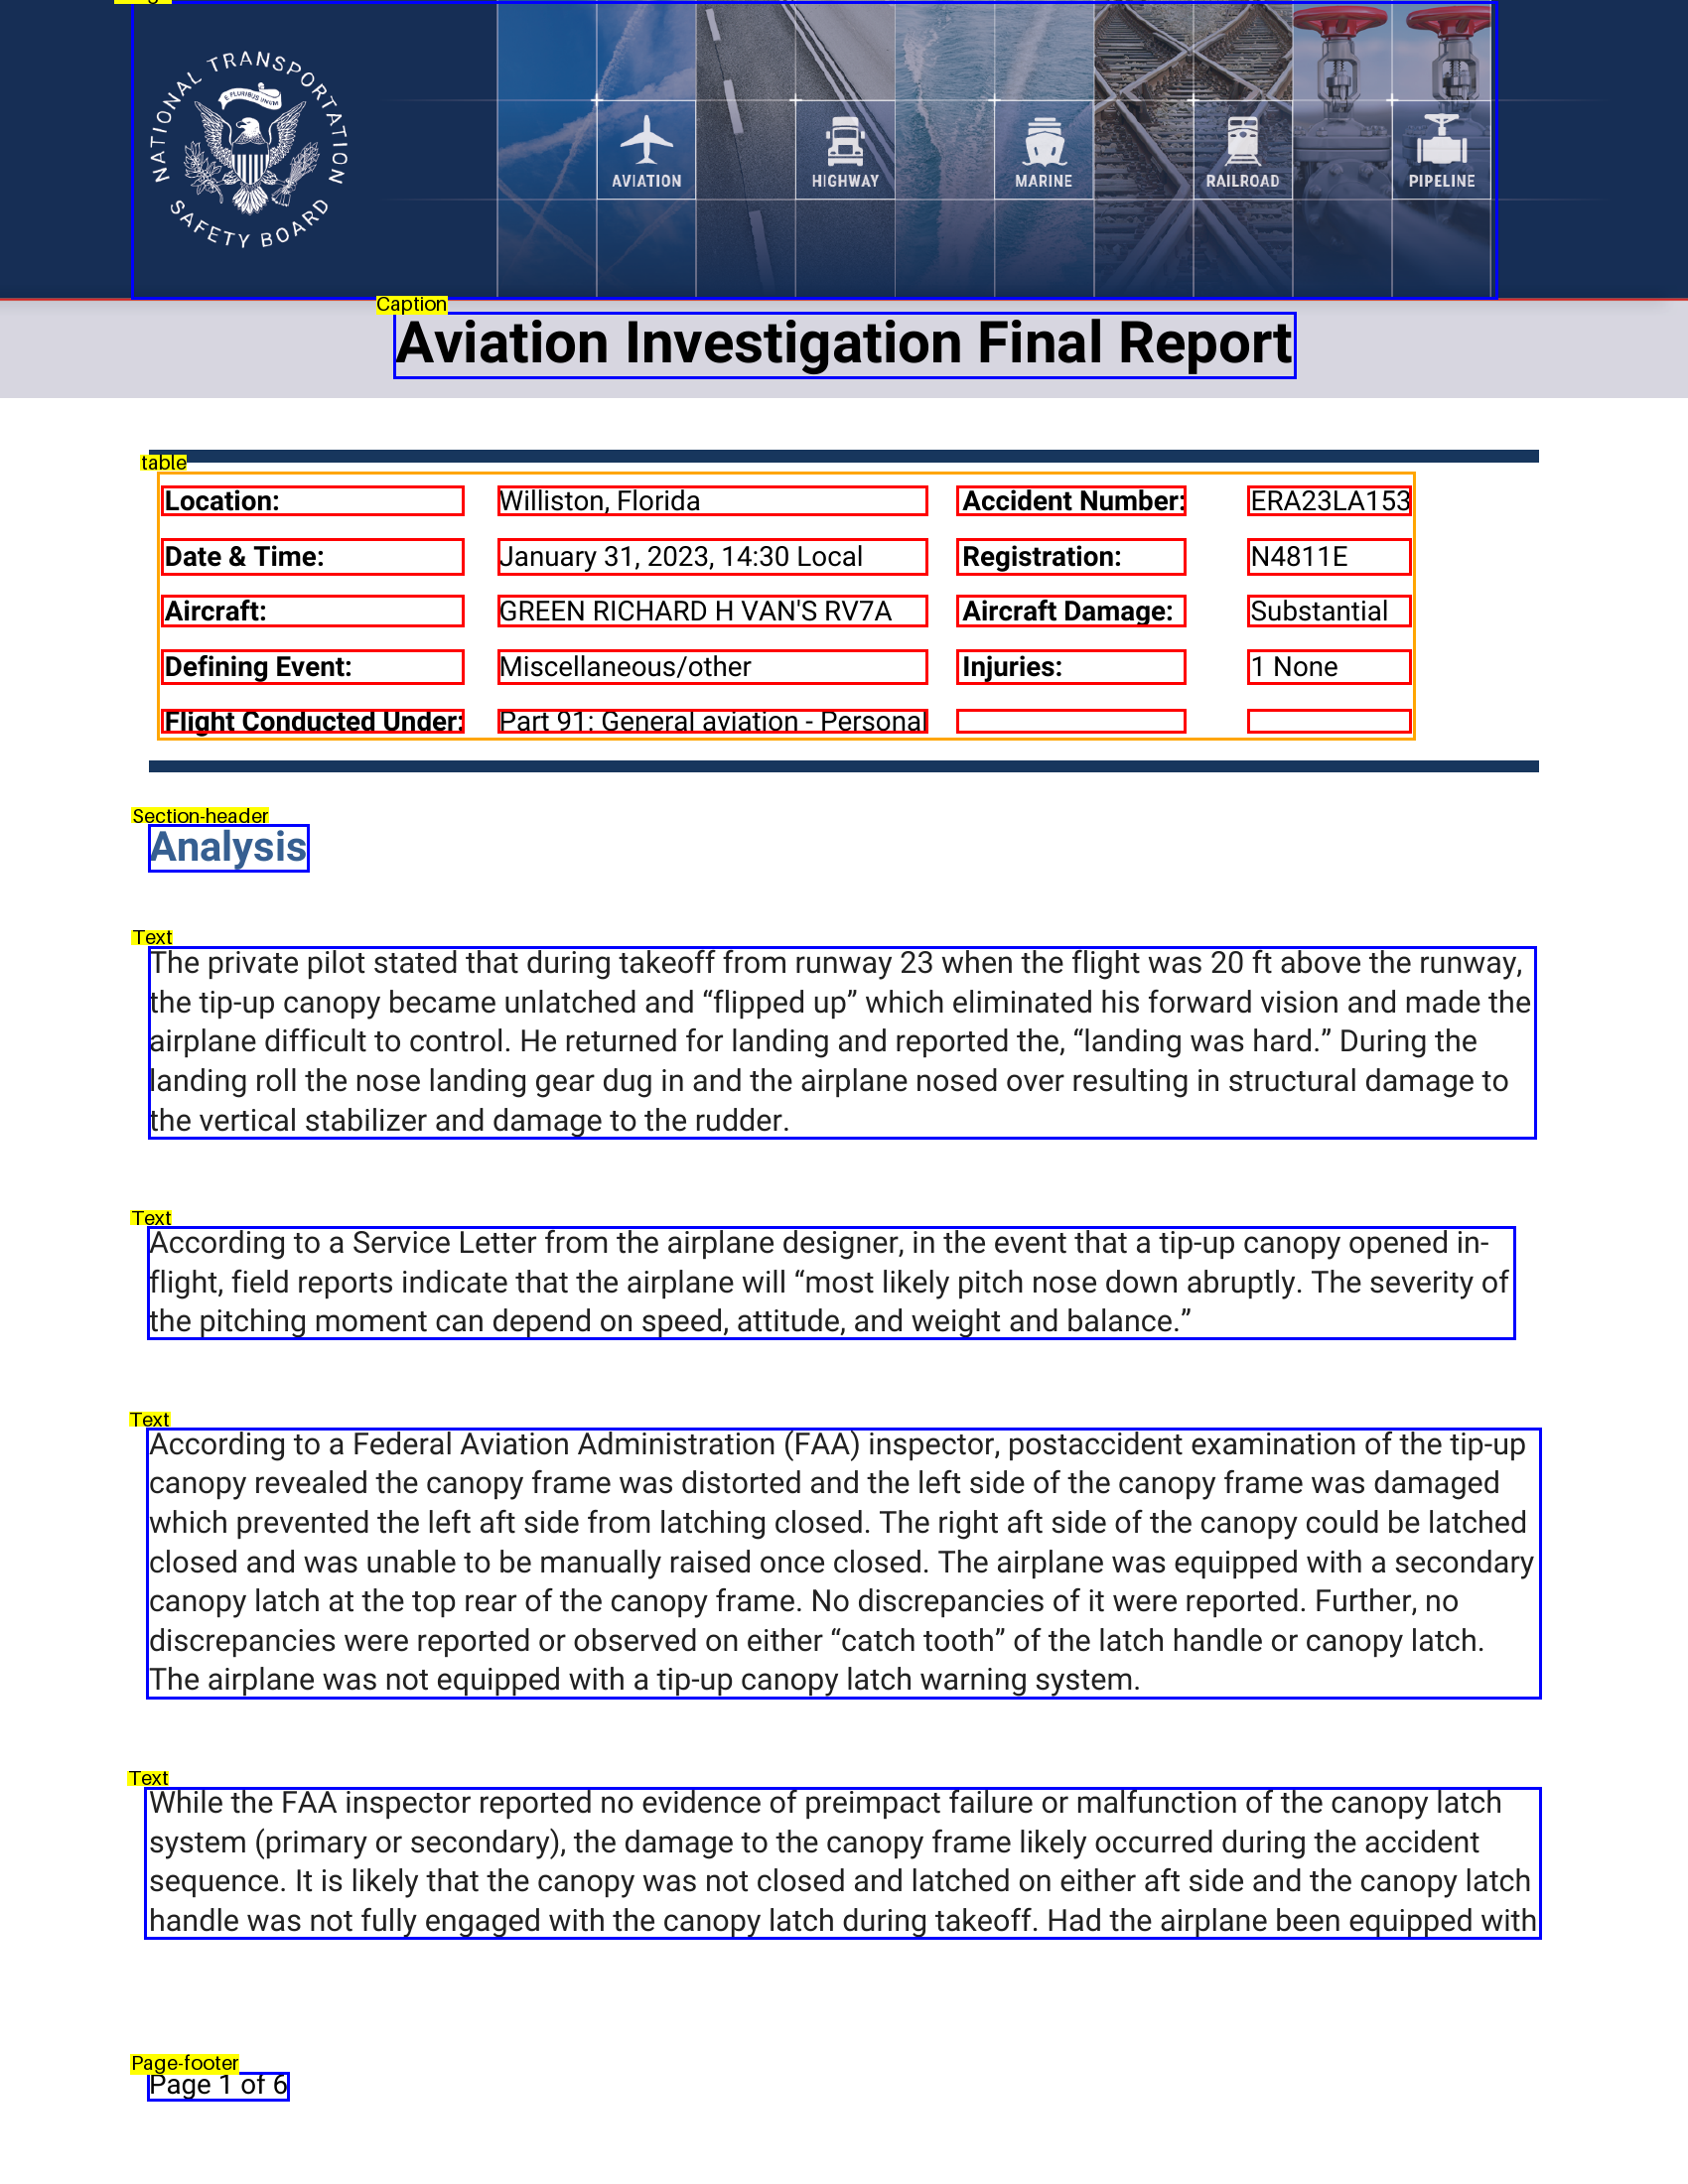

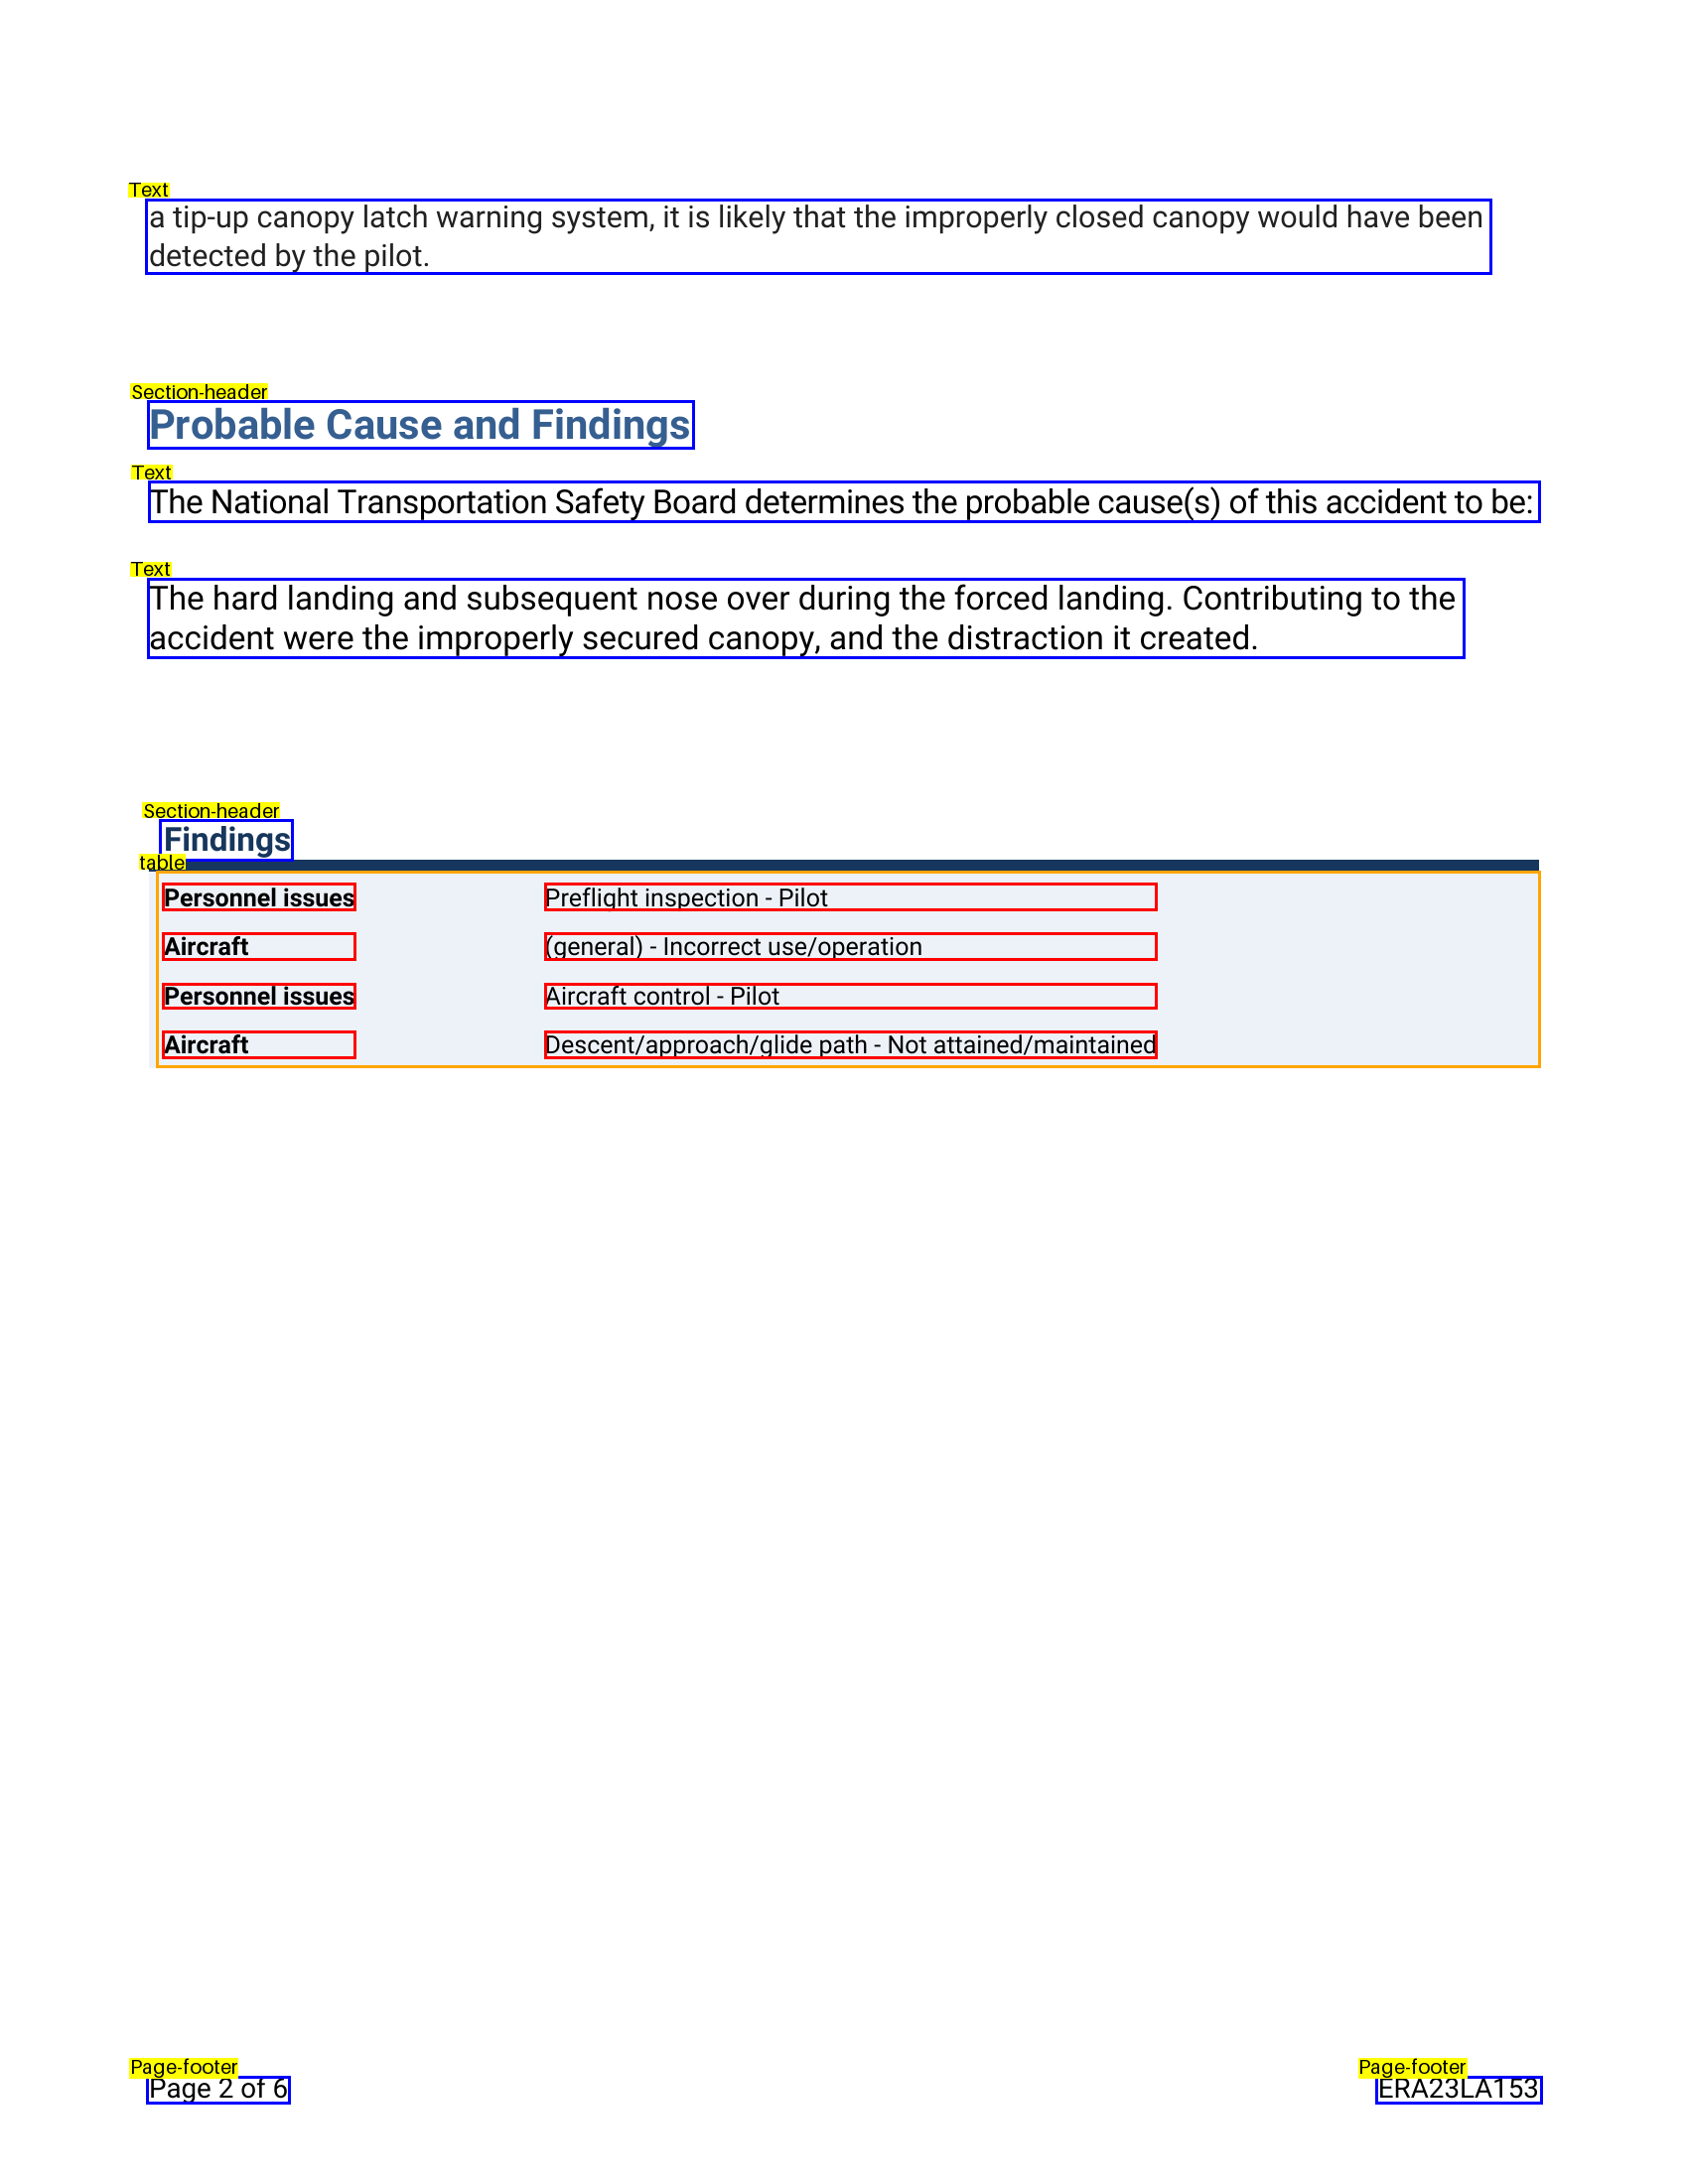

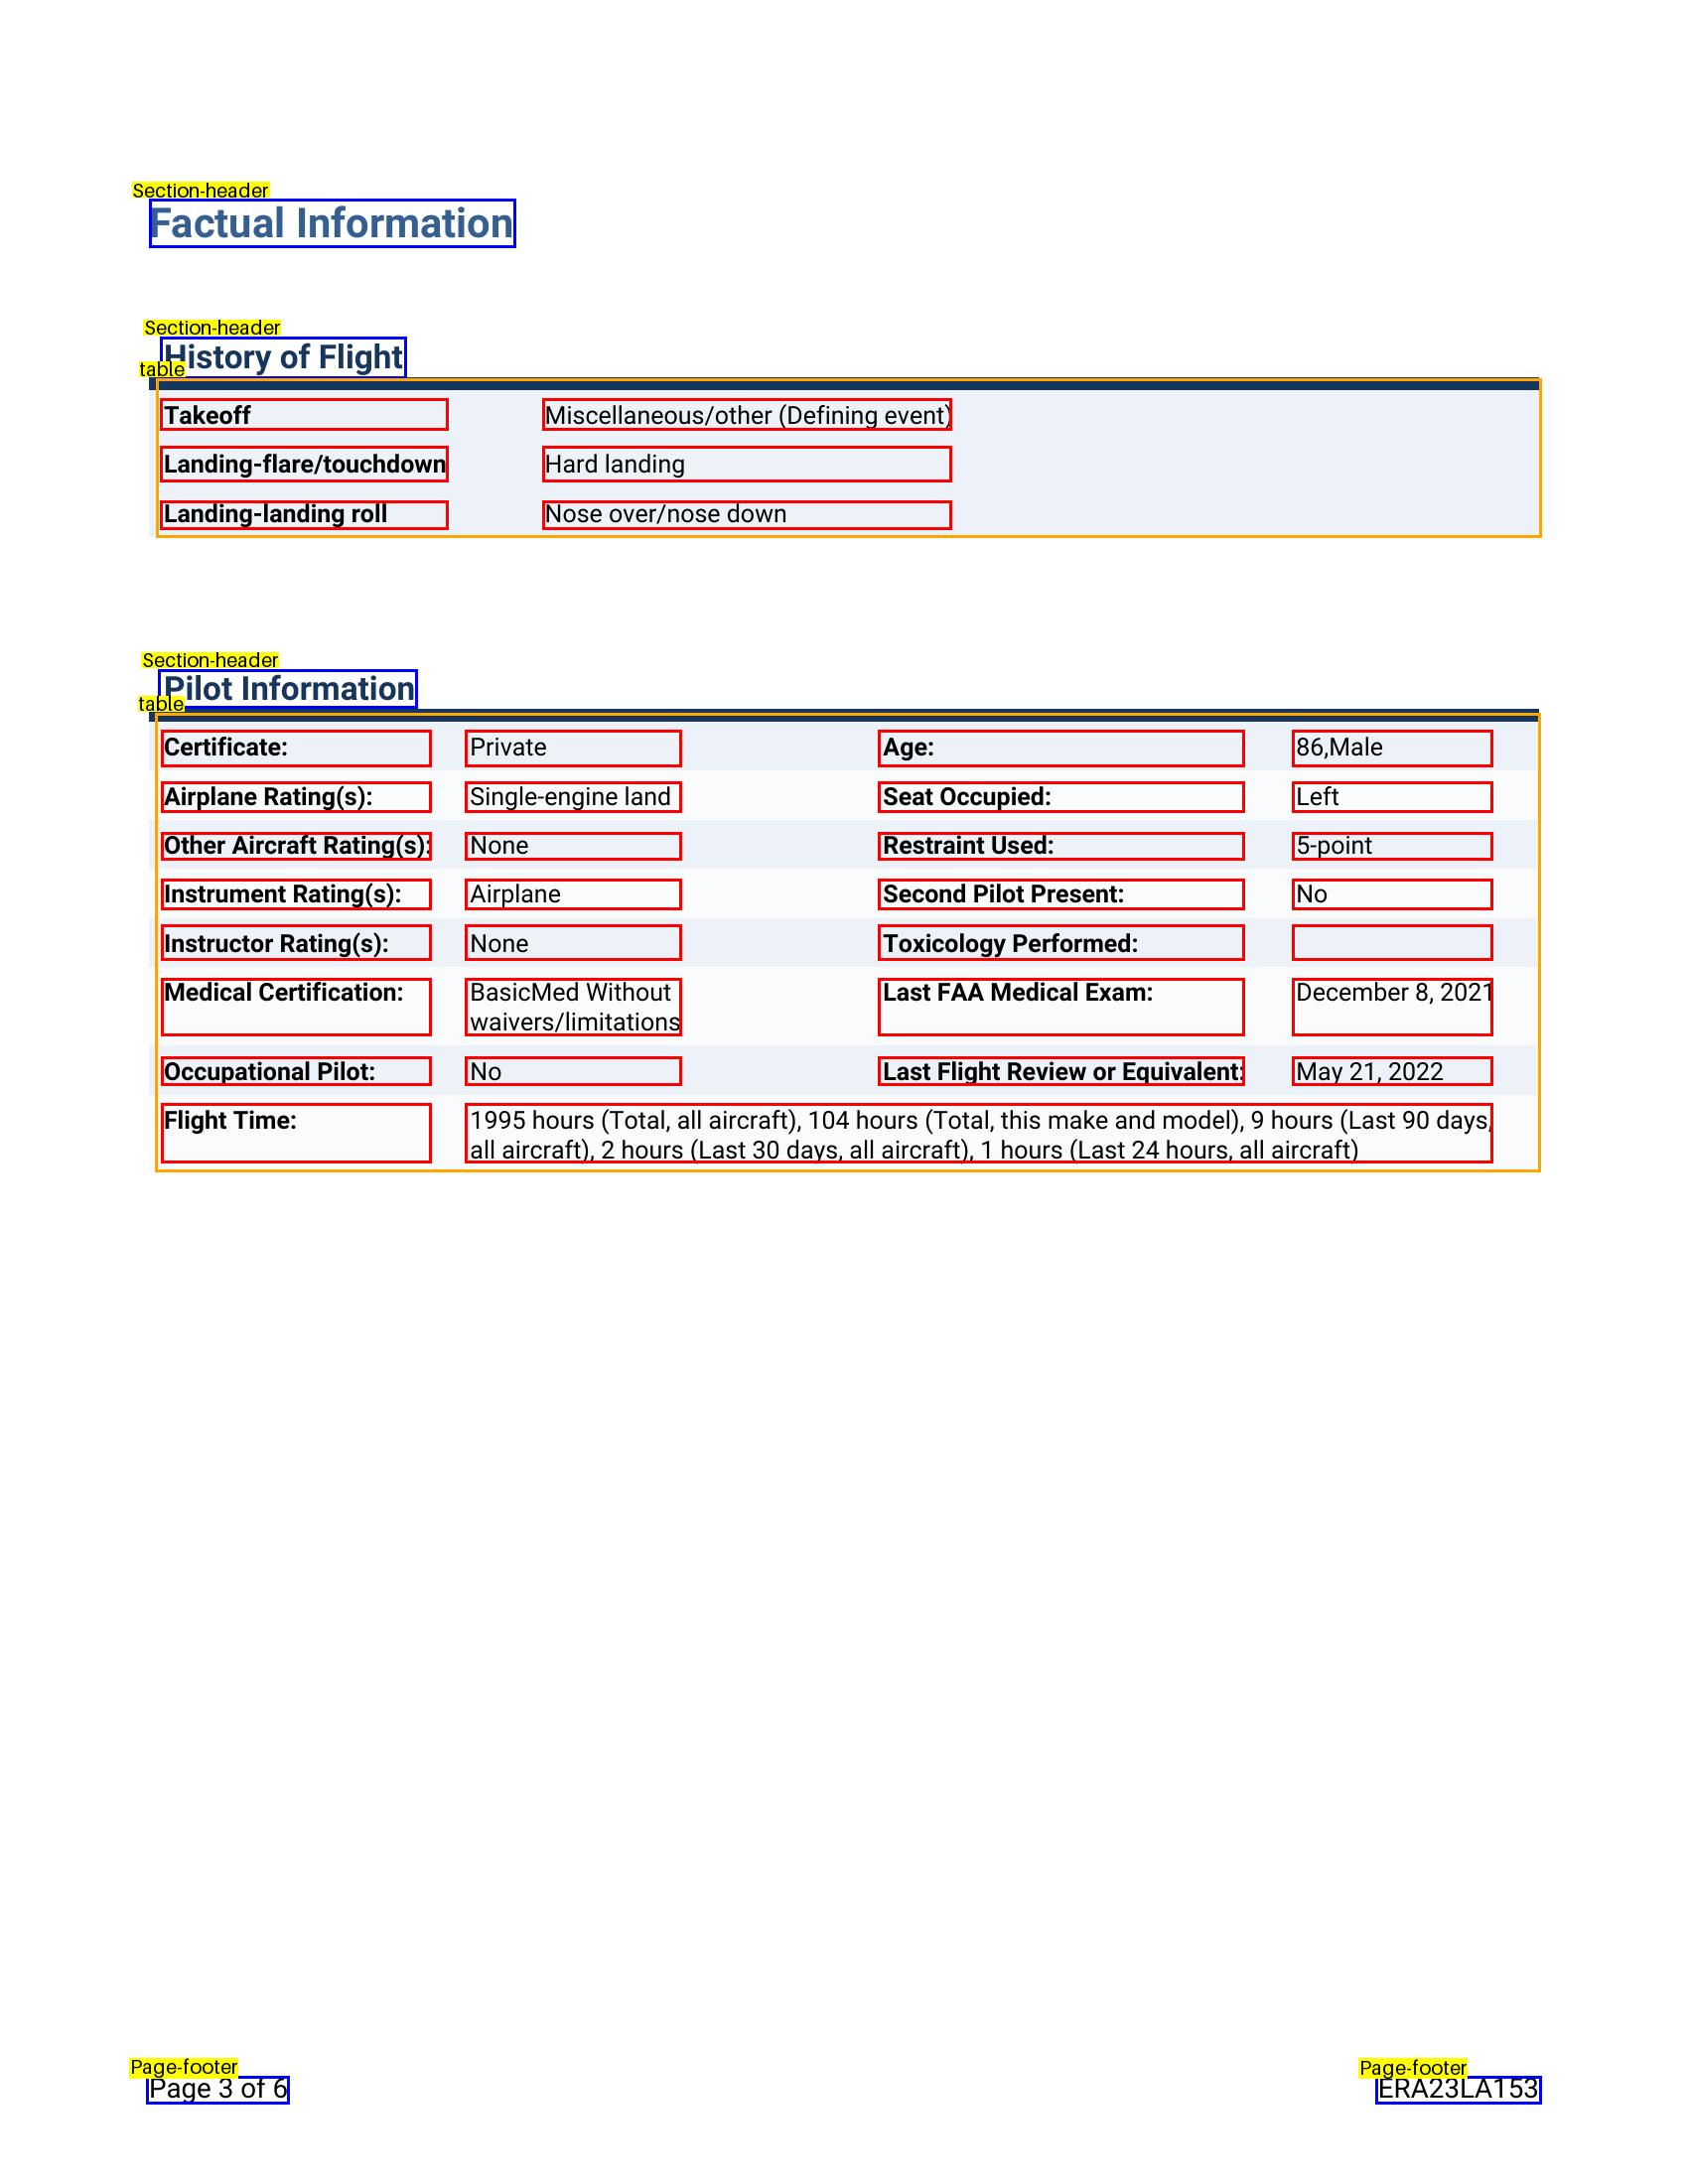

In [22]:
from sycamore.data import Element
from sycamore.transforms.partition import ArynPartitioner

partitioned_doc = doc.partition(ArynPartitioner(extract_table_structure=True, extract_images=True, use_ocr=True))
# Visualize the partitioned document
show_pages(partitioned_doc, limit=3)

## Transforming the Data

Now if we simply embed the elements extracted from DocParse as is, the resulting embeddings won't allow us to answer complex questions. We'll perform a simple transform that attaches the top table as metadata to each chunk that we embed.

In [23]:
def tableglom(doc):
    first_table = list(filter(lambda e: e.type=='table', doc.elements))[0]
    for elt in doc.elements:
        elt['path'] = doc.properties['path']
        if elt is first_table:
            continue
        elt.text_representation = f"Metadata: {first_table.table.to_csv()}\n{elt.text_representation}"

    return doc

doc_transformed = partitioned_doc.map(tableglom)

In [24]:
doc_transformed.show()

sycamore.executor - INFO - 2025-01-11 23:55:20,036 - Executing source BinaryScan


INFO:sycamore.executor:Executing source BinaryScan


sycamore.utils.pyarrow - WARNING - 2025-01-11 23:55:20,038 - path aryn-public/ntsb infers a filesystem of class <class 'pyarrow._fs.LocalFileSystem'> and a path of /Users/vincentwork/Documents/UCSB/SBHacksXI/aryn_pipeline/aryn-public/ntsb, but the specified filesystem is <class 'pyarrow._s3fs.S3FileSystem'>. Using the path unchanged.


sycamore.executor - INFO - 2025-01-11 23:55:51,723 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-11 23:55:51,912 - Executing node Partition


INFO:sycamore.executor:Executing node Partition


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:53,812 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:53,813 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c01c090f-eb6e-4c2a-88b2-3d1ff4d9f3eb


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c01c090f-eb6e-4c2a-88b2-3d1ff4d9f3eb


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:53,813 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:53,814 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:53,814 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:54,837 - ArynPartitioner: T+   1.12: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:54,838 - ArynPartitioner: T+   1.34: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.34: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:54,840 - ArynPartitioner: T+   1.55: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:54,840 - ArynPartitioner: T+   1.77: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.77: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:54,841 - ArynPartitioner: T+   2.00: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.00: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:55,937 - ArynPartitioner: T+   2.12: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.12: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,355 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,358 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=1a8ff385-ae58-4f8e-bcc1-e8bb649c57dd


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=1a8ff385-ae58-4f8e-bcc1-e8bb649c57dd


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,359 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,361 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,364 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,365 - ArynPartitioner: T+   0.85: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:55:58,366 - ArynPartitioner: T+   0.92: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.92: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,748 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,750 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=03b92cd0-a018-44cb-8ada-59c701e04211


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=03b92cd0-a018-44cb-8ada-59c701e04211


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,751 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,752 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,753 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,754 - ArynPartitioner: T+   0.90: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:00,754 - ArynPartitioner: T+   0.97: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.97: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,131 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,132 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=682f01b5-1dbb-499c-8079-1392ef4b093c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=682f01b5-1dbb-499c-8079-1392ef4b093c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,133 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,134 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,134 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:03,135 - ArynPartitioner: T+   0.83: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:04,236 - ArynPartitioner: T+   1.04: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.04: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:04,236 - ArynPartitioner: T+   1.33: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.33: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:04,253 - ArynPartitioner: T+   1.55: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:04,253 - ArynPartitioner: T+   1.65: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.65: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,612 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,614 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=207eefdd-d298-4caf-bfa7-bcd9a23c118f


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=207eefdd-d298-4caf-bfa7-bcd9a23c118f


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,615 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,615 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,616 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:06,617 - ArynPartitioner: T+   0.84: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:07,613 - ArynPartitioner: T+   1.09: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:07,614 - ArynPartitioner: T+   1.31: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.31: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:07,615 - ArynPartitioner: T+   1.41: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.41: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:09,860 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:09,861 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6a1b07e-af87-4b0f-ba4d-5a5bf31707aa


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c6a1b07e-af87-4b0f-ba4d-5a5bf31707aa


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:09,863 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:09,864 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:09,865 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:10,916 - ArynPartitioner: T+   1.10: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:10,918 - ArynPartitioner: T+   1.37: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.37: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:10,921 - ArynPartitioner: T+   1.67: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.67: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:10,923 - ArynPartitioner: T+   1.96: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.96: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:12,016 - ArynPartitioner: T+   2.05: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.05: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,311 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,314 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=1b412508-b804-4656-89cd-9cfa662fec7c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=1b412508-b804-4656-89cd-9cfa662fec7c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,316 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,317 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,319 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:14,319 - ArynPartitioner: T+   0.63: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.63: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:15,393 - ArynPartitioner: T+   1.32: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:15,394 - ArynPartitioner: T+   1.40: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,747 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,750 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5c8fcd94-11b9-4184-b5d5-bbf7fbfb238e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5c8fcd94-11b9-4184-b5d5-bbf7fbfb238e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,751 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,752 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,753 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,754 - ArynPartitioner: T+   0.83: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:17,755 - ArynPartitioner: T+   0.89: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,981 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,983 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=ebf9cd89-4c18-4ba2-b0c7-235b61a2296f


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=ebf9cd89-4c18-4ba2-b0c7-235b61a2296f


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,984 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,985 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,987 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:19,987 - ArynPartitioner: T+   0.85: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:21,058 - ArynPartitioner: T+   1.03: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:21,072 - ArynPartitioner: T+   1.26: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.26: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:21,088 - ArynPartitioner: T+   1.48: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:21,089 - ArynPartitioner: T+   1.61: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.61: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,403 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,404 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=18b58ad5-9828-482a-af67-f2e7d36835e0


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=18b58ad5-9828-482a-af67-f2e7d36835e0


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,405 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,406 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,406 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:23,407 - ArynPartitioner: T+   0.81: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:24,509 - ArynPartitioner: T+   1.10: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:24,528 - ArynPartitioner: T+   1.31: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.31: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:24,529 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,715 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,718 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=4816e40c-0f17-4de9-a254-211b9b9ef245


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=4816e40c-0f17-4de9-a254-211b9b9ef245


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,721 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,722 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,722 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:26,723 - ArynPartitioner: T+   0.77: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.77: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:27,889 - ArynPartitioner: T+   1.03: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:27,891 - ArynPartitioner: T+   1.24: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:27,892 - ArynPartitioner: T+   1.45: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:27,893 - ArynPartitioner: T+   1.65: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.65: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,235 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,241 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=b2e078e2-bb43-4abf-9569-afe598218ae1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=b2e078e2-bb43-4abf-9569-afe598218ae1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,242 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,243 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,244 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,245 - ArynPartitioner: T+   0.81: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:30,246 - ArynPartitioner: T+   0.91: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,654 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,665 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=031871e9-9672-43d5-8fba-40a588adab38


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=031871e9-9672-43d5-8fba-40a588adab38


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,667 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,668 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,671 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:32,676 - ArynPartitioner: T+   0.87: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.87: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:33,651 - ArynPartitioner: T+   1.15: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.15: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:33,675 - ArynPartitioner: T+   1.36: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.36: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:33,683 - ArynPartitioner: T+   1.57: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:33,684 - ArynPartitioner: T+   1.78: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.78: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:33,684 - ArynPartitioner: T+   1.93: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.93: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,480 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,483 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=8c762bc8-c2f1-485f-9de6-dee055fc025a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=8c762bc8-c2f1-485f-9de6-dee055fc025a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,485 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,485 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,486 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,487 - ArynPartitioner: T+   0.82: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.82: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:37,487 - ArynPartitioner: T+   0.89: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,719 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,721 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=eff090de-0a5d-4575-809a-361c8607a56e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=eff090de-0a5d-4575-809a-361c8607a56e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,722 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,722 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,723 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:39,724 - ArynPartitioner: T+   0.99: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.99: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:40,795 - ArynPartitioner: T+   1.20: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.20: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:40,796 - ArynPartitioner: T+   1.48: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:40,797 - ArynPartitioner: T+   1.69: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.69: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:40,798 - ArynPartitioner: T+   1.83: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.83: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,203 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,212 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bb3075d6-ac07-4a8e-ad7d-8e98ca966b01


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bb3075d6-ac07-4a8e-ad7d-8e98ca966b01


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,213 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,214 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,214 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,215 - ArynPartitioner: T+   0.75: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.75: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:43,215 - ArynPartitioner: T+   0.81: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:45,758 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:45,766 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c1a27c0a-ca47-41bb-b761-8d488a1b2324


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c1a27c0a-ca47-41bb-b761-8d488a1b2324


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:45,766 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:45,768 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:45,769 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:46,857 - ArynPartitioner: T+   1.08: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.08: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:46,859 - ArynPartitioner: T+   1.37: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.37: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:46,860 - ArynPartitioner: T+   1.64: Completed work on page 7


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.64: Completed work on page 7


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:46,860 - ArynPartitioner: T+   1.92: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.92: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:47,832 - ArynPartitioner: T+   2.19: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.19: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:47,833 - ArynPartitioner: T+   2.51: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.51: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:47,834 - ArynPartitioner: T+   2.63: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.63: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:50,418 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:50,420 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=14411600-807f-4849-a1e1-d0ae7e8b32f4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=14411600-807f-4849-a1e1-d0ae7e8b32f4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:50,421 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:50,421 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:50,422 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:51,464 - ArynPartitioner: T+   1.03: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:51,466 - ArynPartitioner: T+   1.32: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.32: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:51,467 - ArynPartitioner: T+   1.58: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.58: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:51,469 - ArynPartitioner: T+   1.83: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.83: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:52,567 - ArynPartitioner: T+   2.04: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.04: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:52,568 - ArynPartitioner: T+   2.11: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.11: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:54,845 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:54,848 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=630b2bff-2bbd-451e-a615-4280c0245b07


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=630b2bff-2bbd-451e-a615-4280c0245b07


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:54,849 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:54,851 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:54,853 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:55,870 - ArynPartitioner: T+   1.01: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:55,871 - ArynPartitioner: T+   1.30: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.30: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:55,871 - ArynPartitioner: T+   1.58: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.58: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:55,872 - ArynPartitioner: T+   1.85: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.85: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:56,864 - ArynPartitioner: T+   2.10: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.10: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:56,866 - ArynPartitioner: T+   2.25: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.25: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,327 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,328 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a38ba273-b3a7-4387-82de-27b671a11626


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a38ba273-b3a7-4387-82de-27b671a11626


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,330 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,331 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,332 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,333 - ArynPartitioner: T+   0.74: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.74: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:56:59,334 - ArynPartitioner: T+   0.84: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,674 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,677 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=fa8391b4-566f-44e2-aecc-5fe6199a220f


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=fa8391b4-566f-44e2-aecc-5fe6199a220f


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,680 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,681 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,682 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:01,683 - ArynPartitioner: T+   0.84: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:02,806 - ArynPartitioner: T+   1.05: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:02,829 - ArynPartitioner: T+   1.27: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.27: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:02,844 - ArynPartitioner: T+   1.48: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:02,844 - ArynPartitioner: T+   1.62: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.62: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:05,193 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:05,197 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f63a7a67-e403-4d44-b2a4-34e2f79299f1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f63a7a67-e403-4d44-b2a4-34e2f79299f1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:05,198 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:05,200 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:05,201 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:06,210 - ArynPartitioner: T+   1.16: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.16: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:06,211 - ArynPartitioner: T+   1.78: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.78: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:07,318 - ArynPartitioner: T+   2.03: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.03: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:07,339 - ArynPartitioner: T+   2.24: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.24: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:07,351 - ArynPartitioner: T+   2.46: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.46: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:07,351 - ArynPartitioner: T+   2.60: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.60: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,684 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,685 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=cc3aa900-391a-46c6-8da1-dd4aa18753c5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=cc3aa900-391a-46c6-8da1-dd4aa18753c5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,686 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,688 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,690 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,691 - ArynPartitioner: T+   0.76: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.76: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:09,693 - ArynPartitioner: T+   0.83: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.83: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,910 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,917 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=dd770482-3458-49a2-b0a3-ce2b778b9990


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=dd770482-3458-49a2-b0a3-ce2b778b9990


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,918 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,918 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,919 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:11,919 - ArynPartitioner: T+   0.80: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.80: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:13,052 - ArynPartitioner: T+   1.12: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:13,068 - ArynPartitioner: T+   1.37: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.37: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:13,068 - ArynPartitioner: T+   1.46: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,299 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,302 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=cc310b2e-0e3c-4895-8368-7cb0d0dd9a97


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=cc310b2e-0e3c-4895-8368-7cb0d0dd9a97


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,304 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,305 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,307 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:15,307 - ArynPartitioner: T+   0.81: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:16,426 - ArynPartitioner: T+   1.02: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.02: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:16,427 - ArynPartitioner: T+   1.25: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.25: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:16,428 - ArynPartitioner: T+   1.44: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,708 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,718 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=cbfe5d45-240a-4820-91dd-423fe4a2d9e3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=cbfe5d45-240a-4820-91dd-423fe4a2d9e3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,719 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,720 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,722 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:18,724 - ArynPartitioner: T+   0.98: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.98: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:19,690 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:19,693 - ArynPartitioner: T+   1.67: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.67: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:19,694 - ArynPartitioner: T+   1.89: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.89: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:20,826 - ArynPartitioner: T+   2.18: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.18: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:20,836 - ArynPartitioner: T+   2.26: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.26: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,107 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,109 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a7f20d07-3aae-44b7-a0be-a06204996256


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a7f20d07-3aae-44b7-a0be-a06204996256


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,111 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,112 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,114 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:23,115 - ArynPartitioner: T+   0.97: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.97: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:24,131 - ArynPartitioner: T+   1.20: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.20: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:24,134 - ArynPartitioner: T+   1.47: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.47: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:24,135 - ArynPartitioner: T+   1.76: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.76: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:24,136 - ArynPartitioner: T+   1.97: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.97: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:25,121 - ArynPartitioner: T+   2.11: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.11: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:27,515 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:27,517 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=0a977f87-9c4d-44bf-9f40-36ac615abc54


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=0a977f87-9c4d-44bf-9f40-36ac615abc54


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:27,519 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:27,521 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:27,523 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:28,498 - ArynPartitioner: T+   1.05: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:28,500 - ArynPartitioner: T+   1.33: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.33: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:28,501 - ArynPartitioner: T+   1.48: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:30,720 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:30,721 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5e7c9529-7621-48ff-a2f7-5eb0455c9935


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5e7c9529-7621-48ff-a2f7-5eb0455c9935


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:30,722 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:30,723 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:30,724 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:31,719 - ArynPartitioner: T+   1.02: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.02: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:31,722 - ArynPartitioner: T+   1.24: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:31,722 - ArynPartitioner: T+   1.45: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:31,723 - ArynPartitioner: T+   1.78: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.78: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:32,808 - ArynPartitioner: T+   2.06: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.06: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:32,810 - ArynPartitioner: T+   2.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,150 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,157 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d5b90409-f266-413b-88ea-f2fa718f5667


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d5b90409-f266-413b-88ea-f2fa718f5667


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,159 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,160 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,161 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,162 - ArynPartitioner: T+   0.80: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.80: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:35,162 - ArynPartitioner: T+   0.86: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.86: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,509 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,515 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=9487704b-1a41-4587-a6ab-c6c77e9935ef


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=9487704b-1a41-4587-a6ab-c6c77e9935ef


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,516 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,517 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,517 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:37,518 - ArynPartitioner: T+   0.89: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:38,554 - ArynPartitioner: T+   1.17: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:38,555 - ArynPartitioner: T+   1.25: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.25: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:40,927 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:40,933 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=7b2d89a0-6f91-426e-8bb4-9de97194b234


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=7b2d89a0-6f91-426e-8bb4-9de97194b234


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:40,934 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:40,935 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:40,937 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:41,832 - ArynPartitioner: T+   1.09: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.09: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:41,834 - ArynPartitioner: T+   1.44: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:41,835 - ArynPartitioner: T+   1.66: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.66: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:41,836 - ArynPartitioner: T+   1.91: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.91: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:42,948 - ArynPartitioner: T+   2.18: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.18: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:42,962 - ArynPartitioner: T+   2.27: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.27: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,221 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,225 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=364d3b74-dd63-4dc8-9d0f-cf7fbdef5648


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=364d3b74-dd63-4dc8-9d0f-cf7fbdef5648


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,226 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,227 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,228 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:45,229 - ArynPartitioner: T+   0.96: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.96: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:46,300 - ArynPartitioner: T+   1.22: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.22: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:46,301 - ArynPartitioner: T+   1.53: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.53: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:46,301 - ArynPartitioner: T+   1.60: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.60: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:48,912 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:48,917 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=753cf058-b666-492d-8953-8248648a1eaa


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=753cf058-b666-492d-8953-8248648a1eaa


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:48,919 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:48,920 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:48,921 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:49,897 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:49,899 - ArynPartitioner: T+   1.25: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.25: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:49,901 - ArynPartitioner: T+   1.53: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.53: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:49,902 - ArynPartitioner: T+   1.73: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.73: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:51,046 - ArynPartitioner: T+   2.02: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:51,060 - ArynPartitioner: T+   2.09: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.09: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:53,315 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:53,316 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=159a2958-61f2-4164-b9fe-4de074878ef4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=159a2958-61f2-4164-b9fe-4de074878ef4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:53,317 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:53,317 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:53,318 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:54,356 - ArynPartitioner: T+   1.21: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.21: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:54,359 - ArynPartitioner: T+   1.29: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.29: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,592 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,594 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a61c4796-b61a-4ef9-a120-c1f72037c383


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a61c4796-b61a-4ef9-a120-c1f72037c383


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,595 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,597 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,598 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:56,600 - ArynPartitioner: T+   0.98: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.98: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:57,572 - ArynPartitioner: T+   1.49: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:57,574 - ArynPartitioner: T+   1.73: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.73: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:57,575 - ArynPartitioner: T+   1.95: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.95: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:58,720 - ArynPartitioner: T+   2.21: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.21: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:57:58,731 - ArynPartitioner: T+   2.31: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.31: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:00,997 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:01,000 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=abb4d783-5a7c-41a4-9cf8-fcb681ac4321


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=abb4d783-5a7c-41a4-9cf8-fcb681ac4321


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:01,001 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:01,002 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:01,002 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:01,003 - ArynPartitioner: T+   0.89: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:02,097 - ArynPartitioner: T+   1.14: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.14: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:02,097 - ArynPartitioner: T+   1.43: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.43: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:02,098 - ArynPartitioner: T+   1.50: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.50: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,378 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,379 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=f5331092-9340-422a-b5f0-c6ac6ebb32ef


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=f5331092-9340-422a-b5f0-c6ac6ebb32ef


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,380 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,380 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,381 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:04,381 - ArynPartitioner: T+   0.87: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.87: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:05,439 - ArynPartitioner: T+   1.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:05,440 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:05,441 - ArynPartitioner: T+   1.54: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.54: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:07,764 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:07,766 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bfb013bb-9d96-405f-ae99-2184fb47f949


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bfb013bb-9d96-405f-ae99-2184fb47f949


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:07,767 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:07,768 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:07,769 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:08,779 - ArynPartitioner: T+   1.10: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:08,783 - ArynPartitioner: T+   1.62: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.62: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:08,784 - ArynPartitioner: T+   1.91: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.91: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:09,841 - ArynPartitioner: T+   2.14: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.14: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:09,841 - ArynPartitioner: T+   2.40: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.40: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:09,842 - ArynPartitioner: T+   2.48: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.48: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:12,464 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:12,468 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=c7615c1e-08cb-457c-a601-ea261e83187c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=c7615c1e-08cb-457c-a601-ea261e83187c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:12,469 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:12,470 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:12,471 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:13,386 - ArynPartitioner: T+   1.19: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.19: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:13,388 - ArynPartitioner: T+   1.48: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:13,390 - ArynPartitioner: T+   1.69: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.69: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:13,391 - ArynPartitioner: T+   1.90: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.90: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:13,392 - ArynPartitioner: T+   1.96: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.96: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:17,584 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:17,585 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=21ed28a6-c31e-418b-b059-ee2fa4fa7967


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=21ed28a6-c31e-418b-b059-ee2fa4fa7967


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:17,586 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:17,586 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:17,586 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:18,578 - ArynPartitioner: T+   1.18: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.18: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:18,580 - ArynPartitioner: T+   1.45: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.45: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:18,580 - ArynPartitioner: T+   1.71: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.71: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:18,580 - ArynPartitioner: T+   1.88: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.88: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:19,718 - ArynPartitioner: T+   2.09: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.09: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:19,737 - ArynPartitioner: T+   2.23: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.23: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:22,167 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:22,168 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=1588212d-8278-4b96-b28d-efdfe4964aec


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=1588212d-8278-4b96-b28d-efdfe4964aec


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:22,169 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:22,170 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:22,171 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:23,146 - ArynPartitioner: T+   1.13: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.13: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:23,147 - ArynPartitioner: T+   1.68: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.68: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:23,148 - ArynPartitioner: T+   1.91: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.91: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:24,244 - ArynPartitioner: T+   2.14: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.14: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:24,245 - ArynPartitioner: T+   2.49: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.49: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:24,246 - ArynPartitioner: T+   2.56: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.56: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,595 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,599 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=562f033a-666c-49b2-88ef-e5c11b339f7d


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=562f033a-666c-49b2-88ef-e5c11b339f7d


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,600 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,601 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,603 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:26,604 - ArynPartitioner: T+   0.81: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.81: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:27,601 - ArynPartitioner: T+   1.06: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.06: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:27,602 - ArynPartitioner: T+   1.14: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.14: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,108 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,110 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5ad2b780-6224-477c-97f2-15500a5e34c3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5ad2b780-6224-477c-97f2-15500a5e34c3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,111 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,112 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,113 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:30,113 - ArynPartitioner: T+   0.87: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.87: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:31,282 - ArynPartitioner: T+   1.17: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:31,282 - ArynPartitioner: T+   1.44: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:31,283 - ArynPartitioner: T+   1.55: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,621 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,625 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5427892e-9df9-406f-b7c5-3836080e083a


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5427892e-9df9-406f-b7c5-3836080e083a


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,627 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,628 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,629 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,630 - ArynPartitioner: T+   0.86: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.86: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:33,631 - ArynPartitioner: T+   0.93: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.93: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,221 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,223 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=20bccacd-6344-4313-9772-47665a1b755c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=20bccacd-6344-4313-9772-47665a1b755c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,225 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,226 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,227 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:36,228 - ArynPartitioner: T+   0.94: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.94: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:37,264 - ArynPartitioner: T+   1.16: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.16: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:37,266 - ArynPartitioner: T+   1.40: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:37,266 - ArynPartitioner: T+   1.46: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:39,833 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:39,836 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=0a3d7a2f-6d73-4969-950d-5dd43806a4bb


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=0a3d7a2f-6d73-4969-950d-5dd43806a4bb


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:39,838 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:39,839 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:39,840 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:40,932 - ArynPartitioner: T+   1.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:40,933 - ArynPartitioner: T+   1.42: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.42: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:40,933 - ArynPartitioner: T+   1.70: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.70: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:42,137 - ArynPartitioner: T+   2.01: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.01: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:42,138 - ArynPartitioner: T+   2.27: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.27: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:42,139 - ArynPartitioner: T+   2.35: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.35: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,515 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,517 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=a723e909-ddba-4de3-977d-07b4cfc4dc53


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=a723e909-ddba-4de3-977d-07b4cfc4dc53


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,518 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,519 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,520 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:44,521 - ArynPartitioner: T+   0.92: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.92: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:45,617 - ArynPartitioner: T+   1.25: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.25: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:45,619 - ArynPartitioner: T+   1.49: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.49: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:45,621 - ArynPartitioner: T+   1.71: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.71: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:45,622 - ArynPartitioner: T+   1.85: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.85: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:48,304 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:48,308 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=870ad213-8c88-47f8-b7bd-d09db1407566


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=870ad213-8c88-47f8-b7bd-d09db1407566


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:48,309 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:48,310 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:48,311 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:49,226 - ArynPartitioner: T+   1.05: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:49,227 - ArynPartitioner: T+   1.34: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.34: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:49,229 - ArynPartitioner: T+   1.58: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.58: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:49,230 - ArynPartitioner: T+   1.96: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.96: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:50,294 - ArynPartitioner: T+   2.07: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.07: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:52,810 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:52,813 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=588e5a59-851c-4c26-ad13-71ae8a9543d3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=588e5a59-851c-4c26-ad13-71ae8a9543d3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:52,814 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:52,815 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:52,817 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:53,844 - ArynPartitioner: T+   1.13: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.13: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:53,847 - ArynPartitioner: T+   1.59: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.59: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:53,849 - ArynPartitioner: T+   1.89: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.89: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:54,935 - ArynPartitioner: T+   2.13: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.13: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:54,937 - ArynPartitioner: T+   2.35: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.35: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:54,937 - ArynPartitioner: T+   2.48: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.48: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,319 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,324 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=05e481f2-cf7e-4f86-baae-05cab659fd8b


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=05e481f2-cf7e-4f86-baae-05cab659fd8b


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,326 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,327 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,328 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:57,329 - ArynPartitioner: T+   0.97: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.97: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:58,417 - ArynPartitioner: T+   1.18: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.18: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:58,418 - ArynPartitioner: T+   1.46: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.46: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:58:58,418 - ArynPartitioner: T+   1.55: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.55: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,798 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,802 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=4e9596db-b8a6-460a-b542-d941226c073d


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=4e9596db-b8a6-460a-b542-d941226c073d


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,803 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,804 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,805 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,805 - ArynPartitioner: T+   0.68: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.68: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:00,806 - ArynPartitioner: T+   0.89: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.89: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:01,904 - ArynPartitioner: T+   1.07: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,381 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,382 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=0f0a67a2-5742-4852-8c3e-cbb48d802e81


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=0f0a67a2-5742-4852-8c3e-cbb48d802e81


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,382 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,383 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,383 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:04,384 - ArynPartitioner: T+   0.85: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.85: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:05,378 - ArynPartitioner: T+   1.06: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.06: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:05,381 - ArynPartitioner: T+   1.28: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.28: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:05,384 - ArynPartitioner: T+   1.35: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.35: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,562 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,565 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5e1b98a9-c5c9-4cd3-92f3-847a16daa0ef


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5e1b98a9-c5c9-4cd3-92f3-847a16daa0ef


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,566 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,567 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,567 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:08,568 - ArynPartitioner: T+   0.80: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.80: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:09,691 - ArynPartitioner: T+   1.01: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:09,692 - ArynPartitioner: T+   1.26: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.26: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:09,725 - ArynPartitioner: T+   1.44: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:11,984 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:11,987 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=69e66df1-7b43-4718-a5c8-494b9c785265


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=69e66df1-7b43-4718-a5c8-494b9c785265


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:11,988 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:11,990 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:11,992 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:13,085 - ArynPartitioner: T+   1.17: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:13,086 - ArynPartitioner: T+   1.41: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.41: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:13,086 - ArynPartitioner: T+   1.70: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.70: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:13,086 - ArynPartitioner: T+   1.99: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.99: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:14,086 - ArynPartitioner: T+   2.28: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.28: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:14,087 - ArynPartitioner: T+   2.35: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.35: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,364 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,368 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=e6ddaa36-e1b4-4457-b5c5-865a0c71805c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=e6ddaa36-e1b4-4457-b5c5-865a0c71805c


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,369 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,370 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,371 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:16,372 - ArynPartitioner: T+   0.94: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.94: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:17,472 - ArynPartitioner: T+   1.15: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.15: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:17,482 - ArynPartitioner: T+   1.38: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:17,487 - ArynPartitioner: T+   1.73: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.73: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:17,492 - ArynPartitioner: T+   1.80: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.80: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,774 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,776 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=019b4bff-7f27-41d1-8f64-7a505b7e814e


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=019b4bff-7f27-41d1-8f64-7a505b7e814e


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,776 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,777 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,777 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:19,777 - ArynPartitioner: T+   0.92: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.92: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:20,956 - ArynPartitioner: T+   1.20: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.20: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:20,964 - ArynPartitioner: T+   1.47: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.47: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:20,966 - ArynPartitioner: T+   1.70: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.70: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:20,968 - ArynPartitioner: T+   1.77: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.77: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:23,178 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:23,181 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=2da65e91-b2cf-45f7-9183-7f2497a91e63


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=2da65e91-b2cf-45f7-9183-7f2497a91e63


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:23,182 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:23,183 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:23,184 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:24,325 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:24,329 - ArynPartitioner: T+   1.35: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.35: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:24,330 - ArynPartitioner: T+   1.64: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.64: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:24,331 - ArynPartitioner: T+   1.88: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.88: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:24,331 - ArynPartitioner: T+   1.96: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.96: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:26,611 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:26,612 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=336ce79e-340c-4e2c-bd4d-8aaec5d9936b


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=336ce79e-340c-4e2c-bd4d-8aaec5d9936b


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:26,613 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:26,614 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:26,615 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:27,704 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:27,705 - ArynPartitioner: T+   1.18: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.18: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:30,026 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:30,029 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d8f06671-9dad-4c7f-ac60-1d2a0952c97b


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d8f06671-9dad-4c7f-ac60-1d2a0952c97b


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:30,030 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:30,032 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:30,032 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:31,103 - ArynPartitioner: T+   1.01: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.01: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:31,104 - ArynPartitioner: T+   1.07: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.07: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,464 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,466 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=dbea4b04-490f-42a0-b7ce-21b86d8617e2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=dbea4b04-490f-42a0-b7ce-21b86d8617e2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,467 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,468 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,469 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:33,470 - ArynPartitioner: T+   0.84: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.84: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:34,500 - ArynPartitioner: T+   1.03: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.03: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:34,502 - ArynPartitioner: T+   1.23: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,742 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,743 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=fdec635d-f80c-4e3e-b0a4-83533cec65dc


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=fdec635d-f80c-4e3e-b0a4-83533cec65dc


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,743 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,744 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,746 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,747 - ArynPartitioner: T+   0.74: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.74: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:36,747 - ArynPartitioner: T+   0.94: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.94: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:37,845 - ArynPartitioner: T+   1.12: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.12: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:40,085 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:40,091 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=344897e2-0b9a-4d57-8c91-f92fd604c983


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=344897e2-0b9a-4d57-8c91-f92fd604c983


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:40,092 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:40,093 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:40,094 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:41,143 - ArynPartitioner: T+   1.05: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.05: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:41,143 - ArynPartitioner: T+   1.27: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.27: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:41,144 - ArynPartitioner: T+   1.48: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.48: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:41,145 - ArynPartitioner: T+   1.71: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.71: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:42,243 - ArynPartitioner: T+   2.02: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.02: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:42,243 - ArynPartitioner: T+   2.10: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.10: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:44,523 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:44,524 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bcfa6e94-4fca-440b-9305-a8b18a212571


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bcfa6e94-4fca-440b-9305-a8b18a212571


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:44,525 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:44,526 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:44,527 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:45,546 - ArynPartitioner: T+   1.11: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.11: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:45,547 - ArynPartitioner: T+   1.40: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.40: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:45,548 - ArynPartitioner: T+   1.68: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.68: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:45,548 - ArynPartitioner: T+   1.94: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.94: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:46,584 - ArynPartitioner: T+   2.03: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.03: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:48,936 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:48,938 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=ef601dd9-2f86-41cb-882e-097cc8b4c815


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=ef601dd9-2f86-41cb-882e-097cc8b4c815


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:48,939 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:48,940 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:48,941 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:49,936 - ArynPartitioner: T+   1.14: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.14: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:49,937 - ArynPartitioner: T+   1.34: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.34: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:49,938 - ArynPartitioner: T+   1.54: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.54: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:49,938 - ArynPartitioner: T+   1.83: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.83: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:51,050 - ArynPartitioner: T+   2.04: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.04: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:51,062 - ArynPartitioner: T+   2.27: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.27: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,330 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,332 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=291118b6-fae5-437d-9d1d-b3814a6ad2f4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=291118b6-fae5-437d-9d1d-b3814a6ad2f4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,333 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,334 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,335 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,336 - ArynPartitioner: T+   0.93: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.93: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:53,337 - ArynPartitioner: T+   1.00: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.00: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,672 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,674 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=e0a6d57b-2884-4817-9109-a16705cc7643


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=e0a6d57b-2884-4817-9109-a16705cc7643


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,675 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,676 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,677 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:56,677 - ArynPartitioner: T+   0.90: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:57,755 - ArynPartitioner: T+   1.10: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-11 23:59:57,756 - ArynPartitioner: T+   1.27: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.27: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:00,056 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:00,059 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=5d851836-972c-4733-83fd-9ac97cab8b18


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=5d851836-972c-4733-83fd-9ac97cab8b18


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:00,060 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:00,066 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:00,068 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:01,045 - ArynPartitioner: T+   1.17: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.17: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:01,047 - ArynPartitioner: T+   1.38: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.38: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:01,047 - ArynPartitioner: T+   1.57: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.57: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:01,048 - ArynPartitioner: T+   1.78: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.78: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:02,139 - ArynPartitioner: T+   2.05: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.05: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:02,140 - ArynPartitioner: T+   2.12: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.12: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:04,481 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:04,483 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=81e3c89c-23f0-4cb6-be8a-1c4841db341b


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=81e3c89c-23f0-4cb6-be8a-1c4841db341b


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:04,484 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:04,485 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:04,486 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:05,483 - ArynPartitioner: T+   1.13: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.13: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:05,484 - ArynPartitioner: T+   1.42: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.42: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:05,486 - ArynPartitioner: T+   1.70: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.70: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:06,573 - ArynPartitioner: T+   2.05: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.05: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:06,574 - ArynPartitioner: T+   2.11: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.11: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:08,889 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:08,891 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=6a6bdcd9-90e9-430a-a889-455a25e93d96


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=6a6bdcd9-90e9-430a-a889-455a25e93d96


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:08,892 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:08,892 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:08,893 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:09,894 - ArynPartitioner: T+   1.02: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.02: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:09,895 - ArynPartitioner: T+   1.23: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.23: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:09,896 - ArynPartitioner: T+   1.44: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.44: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:09,897 - ArynPartitioner: T+   1.69: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.69: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:09,897 - ArynPartitioner: T+   1.92: Completed work on page 6


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.92: Completed work on page 6


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:10,970 - ArynPartitioner: T+   2.01: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   2.01: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,253 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,254 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=bbd25f6f-4a74-4830-bd46-1e8e5795f758


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=bbd25f6f-4a74-4830-bd46-1e8e5795f758


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,255 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,256 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,256 - ArynPartitioner: T+   0.00: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:13,257 - ArynPartitioner: T+   0.91: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.91: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:14,329 - ArynPartitioner: T+   1.22: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.22: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:14,332 - ArynPartitioner: T+   1.51: Completed work on page 4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.51: Completed work on page 4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:14,332 - ArynPartitioner: T+   1.73: Completed work on page 5


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.73: Completed work on page 5


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:14,333 - ArynPartitioner: T+   1.84: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.84: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,617 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,619 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=d939b79f-147b-4e3b-a433-d2136a737bbd


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=d939b79f-147b-4e3b-a433-d2136a737bbd


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,620 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,621 - ArynPartitioner: T+   0.01: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,623 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:16,624 - ArynPartitioner: T+   0.90: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.90: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:17,694 - ArynPartitioner: T+   1.10: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.10: Completed work on page 1


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:17,696 - ArynPartitioner: T+   1.24: Completed work on page 3


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   1.24: Completed work on page 3


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,181 - ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Server version aryn-partitioner-0.20241226.161207 Model version 1.4


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,182 - ArynPartitioner: T+   0.00: Received request with aryn_call_id=4e8dc329-208a-4cf1-851e-fec551f0d34c


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Received request with aryn_call_id=4e8dc329-208a-4cf1-851e-fec551f0d34c


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,183 - ArynPartitioner: T+   0.00: Waiting for scheduling


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Waiting for scheduling


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,183 - ArynPartitioner: T+   0.00: Preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.00: Preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,184 - ArynPartitioner: T+   0.01: Done preprocessing document


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.01: Done preprocessing document


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,184 - ArynPartitioner: T+   0.64: Completed work on page 2


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.64: Completed work on page 2


sycamore.transforms.detr_partitioner - INFO - 2025-01-12 00:00:20,185 - ArynPartitioner: T+   0.74: Completed work on page 1


INFO:sycamore.transforms.detr_partitioner:ArynPartitioner: T+   0.74: Completed work on page 1


sycamore.executor - INFO - 2025-01-12 00:00:20,669 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


sycamore.executor - INFO - 2025-01-12 00:00:21,197 - Executing node tableglom


INFO:sycamore.executor:Executing node tableglom


sycamore.executor - INFO - 2025-01-12 00:00:21,748 - Executing node Materialize


INFO:sycamore.executor:Executing node Materialize


{'properties': {'path': 'aryn-public/ntsb/0.pdf',
                'filetype': 'application/pdf'},
 'elements': [{'type': 'Image',
               'bbox': [0.07765141206629136,
                        0.0007932260903445157,
                        0.8870749798943015,
                        0.1369122314453125],
               'properties': {'score': 0.645779550075531,
                              'image_size': [1396, 319],
                              'image_mode': 'RGB',
                              'image_format': None,
                              'page_number': 1,
                              '_element_index': 0},
               'text_representation': 'Metadata: Location:,"Williston, '
                                      'Florida",Accident Number:,ERA23LA153\n'
                                      'Date & Time:,"January 31, 2023, <265 '
                                      'chars>',
               'binary_representation': b'<1335972 bytes>',
               'path': 'aryn-publ

## Embedding

Now we can embed our elements and be sure that they will have sufficient context to a) be retrieved, and b) be meaningful towards the downstream task. The explode transform converts Elements to Documents, which is useful since we want to embed and index each element independently

In [ ]:
from sycamore.transforms.explode import Explode
from sycamore.transforms.merge_elements import GreedySectionMerger
from sycamore.functions.tokenizer import HuggingFaceTokenizer
from sycamore.transforms.embed import SentenceTransformerEmbedder

tokenizer = HuggingFaceTokenizer("thenlper/gte-small")
embedder = SentenceTransformerEmbedder(model_name="thenlper/gte-small", batch_size=100)

embedded_docs = doc_transformed.explode().embed(embedder)

embedded_docs.take_all() #converts a doc set --> list of docs, then use a for loop

## Write to Pinecone

Finally, we write the document to a Pinecone index.

In [ ]:
from sycamore.connectors.pinecone import PineconeWriter, PineconeWriterClientParams, PineconeWriterTargetParams
from pinecone import ServerlessSpec
from pinecone.grpc import PineconeGRPC as Pinecone

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
pc.delete_index('sb-hacks-demo')

In [ ]:
#Create Pinecone Index
index_name = 'sb-hacks-demo'
pc.create_index(
  name=index_name,
  dimension=384,
  metric="cosine",
  spec=ServerlessSpec(
    cloud="aws",
    region="us-east-1"
  ),
  deletion_protection="disabled"
)


In [ ]:
from sys import getsizeof

index = pc.Index(index_name)

#Insert each record into pinecone index
insert_ls = []
counter = 0
for d in embedded_docs.take_all():
  if 'embedding' in d:
    n_dict = {}
    n_dict['id'] = d.doc_id
    n_dict['values'] = d.pop('embedding', [])
    n_dict['metadata'] = {'text_representation' : d.text_representation, 'source' : 'default', 'file' : d['path']}
    insert_ls.append(n_dict)



for i in range(0, len(insert_ls), 20):
  index.upsert(
      vectors=insert_ls[i:i+20])

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain.chains import RetrievalQAWithSourcesChain
import os

# Finally, we initialize a RAG agent and ask the model a question about the data
llm = ChatAnthropic(
    anthropic_key=os.environ.get("anthropic_key"),
    model_name='claude-3-5-sonnet-20241022',
    temperature=0.8
)

In [ ]:
# We now initialize a vector store on Pinecone using the LangChain integration. We perform similarity search using the integration here

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore

embeddings = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
pinecone_vector_store = PineconeVectorStore.from_existing_index(index_name, embeddings, text_key = 'text_representation')

qa = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=pinecone_vector_store.as_retriever() , verbose=True,
    return_source_documents= True
)

In [ ]:
## Answered in document 101
qa.invoke({"question": "How old was the pilot who crashed the flight in Old Bridge NJ?"})['answer']

In [ ]:
qa.invoke({"question": "How old was the pilot who crashed the flight in Old Bridge NJ?"})['source_documents']

In [ ]:
## Answered in document 25
qa.invoke({"question": "For the crash with the Registration number N747PK, what caused the fire?"})['answer']

In [ ]:
## Answered in document 27
qa.invoke({"question": "Where was the digital flight recorder shipped to for the flight that crashed on January 23, 2023?"})['answer']


In [ ]:
## Answered in document 42
qa.invoke({"question": "For the Cessna 172M that crashed in Skull Valley, how long had it been since the last FAA medical exam?"})['answer']
